In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import re
import logomaker

import glob

darks=['#3a80b0','#ff7200', '#984ea3', '#7fc97f',  '#e261b0']
pastels=['#b3cde3','#fed9a6','#decbe4','#ccebc5',  '#f4cae4']

    
SNP_loc={'A': 1032, 'C':1032, 'D':823, 'E':932, 'F':955}
term_start={'A': 1033, 'C': 1033, 'D':824, 'E': 933, 'F':956}
term_end={'A': 1210, 'C': 1210, 'D':1001, 'E':1110, 'F':1133}
LH_start=133
RH_end={'A': 2109, 'C': 2109, 'D': 2001, 'E': 2110, 'F': 2133}
term_len=179
RH_to_gfp=104
GFPlen=718

# set the font name for a font family
plt.rcParams.update({'font.sans-serif':'Arial'})

In [4]:
#this code converts everything so that position indexing matches snapgene file (first base at 1)
#ie. bases[0] should be blank and the first base is at bases[1] (instead of standard for python where indices start at 0)

def read_sam_file(file): #use this just to see what file looks like
    genomes={}
    bases={}
    N=20 #change this to show a different number of lines
    with open(file, 'r') as f:
        counter=0
        for line in f:
            # see all lines
            print(line)
            counter+=1
            if counter==N: break
            

def read_sam_file2(file): #use this to feed into plotting functions
    genomes={}
    bases={}
    profiles={}
    quals={}
    mapq=[]
#     N=30
    with open(file, 'r') as f:
#         counter=0
        for line in f:
#             print(line)
            field=line.strip().split()
            if field[0]=='@SQ': #extracts genomes (should only be reference) and lengths from file
                name=field[1].split(':')[1]
                length=field[2].split(':')[1]
                genomes[name]=int(length)
#                 print(genomes)
            if line[0]!='@': #parses read lines 
                name=field[2]
                mapq.append(int(field[4]))
                if field[2] in genomes and int(field[4]) >= 20: #checks that sequence is aligned to genome and high enough quality
#                     print(name)            
                    if name in bases.keys(): #add on to existing bases/profiles
                        profiles[name]=add_to_profiles(field, profiles[name])
                        bases[name]=add_to_one_hot(field, bases[name])
                        quals[name]=add_to_quals(field, quals[name])
#                         mapq.append(int(field[4]))
                        
                    else: #make new bases/profiles for ea/ sample (empty zero arrays)
                        bases[name]=np.zeros([5, int(length)+1])
                        profiles[name]=np.zeros([int(length)+1])
                        quals[name]=[[]for x in range(int(length)+1)]
                        
                        profiles[name]=add_to_profiles(field, profiles[name])
                        bases[name]=add_to_one_hot(field, bases[name])
                        quals[name]=add_to_quals(field, quals[name])
#                         mapq.append(int(field[4]))
                    
#                   field[1]=='0' means mapped to fwd strand
#                   field[1]=='16' means mapped to rev strand, but gives seq start and seq as if for fwd strand
#             counter+=1
#             if counter ==N: break
    
    print(genomes)
    print(bases.keys())
    return(profiles, bases, quals, mapq)

def add_to_profiles(field, profiles):
    name=field[0]
    flag=field[1]
    cigar=field[5]
    start=int(field[3])
    seq=field[9]
    segs=re.findall('\d*\D+', cigar)
    

    pos=start
    for seg in segs:
        seg_type=seg[-1]
        seg_length=int(seg[0:-1])
        if seg_type=='M':
            profiles[pos:pos+seg_length]+=1
            pos+=seg_length
        elif seg_type=='D':
            pos+=seg_length
        elif seg_type=='I':
            profiles[pos]+=1
            pos=pos
        elif seg_type=='S':
            pos=pos
        else:
            print('error: not M, D, I, or S')
            print(cigar)
    

    return(profiles)         
    

def add_to_one_hot(field, bases):
#     bases[0] A
#     bases[1] C
#     bases[2] G
#     bases[3] T
#     bases[4] insertions

    name=field[0]
    cigar=field[5]
    start=int(field[3])
    seq=field[9]
#     print(cigar)
#     print(start)
#     print(seq)

    segs=re.findall('\d*\D+', cigar)
#     print(segs)
    i=0 # i keeps track of position along read sequence
    pos=start # pos keeps track of position along template sequence
#     print(pos)
#     print(i)
    for seg in segs:
        seg_type=seg[-1]
        seg_length=int(seg[0:-1])
        seg_seq=seq[i:i+seg_length]

#         print(i)
#         print(seg)
#         print(seg_seq)
#         print(pos)
        if seg_type=='M':
            j=0 # j keeps track of position along cigar
            for base in seg_seq:
                if base=='A':
                    bases[0][pos+j]+=1
                elif base=='C':
                    bases[1][pos+j]+=1
                elif base=='G':
                    bases[2][pos+j]+=1
                elif base=='T':
                    bases[3][pos+j]+=1
                elif base=='N':
                    print('N: no value assigned')
                else:
                    print('error: base not A, C, G, or T')
                    print(seq)
                j+=1
            pos+=seg_length
            i+=seg_length

        elif seg_type=='I':
            bases[4][pos]+=1 #only indicates that there is an insertion, but not length of insertion
            i+=seg_length
            #position along template seq (pos) stays the same, but position along read seq (i) moves by length of insertion           
        elif seg_type=='D':
            pos+=seg_length
            #position along template seq (pos) moves by deletion length, but position along read seq (i) stays the same
        elif seg_type=='S':
            i+=seg_length
            #position along template seq (pos) stays the same, but position along read seq (i) moves by length of clipped area
            #nothing is recorded
        else:
            print('error: cigar not M, I, D, or S')
#         print(i)
#         print(pos)
#         print(bases[:,start:pos])
#         print(i)
#         print(pos)
#     print(bases)
    return(bases)


def add_to_quals(field, quals):
    name=field[0]
    cigar=field[5]
    start=int(field[3])
    scores=field[10]
    seq=field[9]
#     print(cigar)
#     print(start)
#     print(scores)

    segs=re.findall('\d*\D+', cigar)
#     print(segs)      

    i=0 # i keeps track of position along qual string (should match read sequence)
    pos=start # pos keeps track of position along template sequence

    for seg in segs:
        seg_type=seg[-1]
        seg_length=int(seg[0:-1])
        seg_score=scores[i:i+seg_length]
#         print(seg_score)
        
        if seg_type=='M':
            j=0 # j keeps track of position along qual string for this segment of cigar
            for score in seg_score:
                quals[pos+j].append(ord(score)-33)
                j+=1
#             print(quals[pos:pos+j])
            pos+=seg_length
            i+=seg_length
            
        elif seg_type=='I':
            i+=seg_length
            #position along template seq (pos) stays the same, but position along read seq (i) moves by length of insertion           
        elif seg_type=='D':
            pos+=seg_length
            #position along template seq (pos) moves by deletion length, but position along read seq (i) stays the same
        elif seg_type=='S':
            i+=seg_length
            #position along template seq (pos) stays the same, but position along read seq (i) moves by length of clipped area
            #nothing is recorded
        else:
            print('error: cigar not M, I, D, or S')
            print('cigar')
#         print(quals[start: start+pos])
#         print(i)
#         print(pos)
        
    return(quals)

def convert_to_one_hot(seq):
    #     bases[0] A
    #     bases[1] C
    #     bases[2] G
    #     bases[3] T
    bases=np.zeros([5, len(seq)+1])
    i=1
    for base in seq.upper():
        if base=='A':
            bases[0][i]+=1
        elif base=='C':
            bases[1][i]+=1
        elif base=='G':
            bases[2][i]+=1
        elif base=='T':
            bases[3][i]+=1
        i+=1
    return(bases)

def revert_to_seq(bases): #use as a way to check one-hot encoding
#     bases[0] A
#     bases[1] C
#     bases[2] G
#     bases[3] T
#     bases[4] insertions

    seq_out=''
    for A, C, G, T in zip(bases[0], bases[1], bases[2], bases[3]):
        if A==1 and C==0 and G==0 and T==0:
            seq_out +='A'
        elif C==1 and A==0 and G==0 and T==0:
            seq_out += 'C'
        elif G==1 and A==0 and C==0 and T==0:
            seq_out += 'G'
        elif T==1 and A==0 and C==0 and G==0:
            seq_out += 'T'
        elif A==0 and C==0 and G==0 and T==0:
            seq_out+= '-'
        else:
            print('error')
    return(seq_out)

# def plot_seq(bases, lower, upper, ax):
    
#     ax.bar(np.arange(lower, upper), bases[0][lower:upper], color='red')
#     ax.bar(np.arange(lower, upper), bases[1][lower:upper], bottom=bases[0][lower:upper], color='blue')
#     ax.bar(np.arange(lower, upper), bases[2][lower:upper], 
#            bottom=bases[0][lower:upper]+bases[1][lower:upper], color='green')
#     ax.bar(np.arange(lower, upper), bases[3][lower:upper], 
#            bottom=bases[0][lower:upper]+bases[1][lower:upper]+bases[2][lower:upper], color='yellow')
#     ax.bar(np.arange(lower, upper), bases[4][lower:upper], 
#            bottom=bases[0][lower:upper]+bases[1][lower:upper]+bases[2][lower:upper]+bases[3][lower:upper], color='grey')
    
# #     fig, ax=plt.subplots(figsize=(40,5), dpi=300)
    
# #     plt.show()
# #     plt.tight_layout()
# #     fig.savefig('./output/' + fname+'.pdf', bbox_inches='tight')
# #     plt.close()
    
    
def plot_profile(profiles, lower, upper, ax):
    ax.bar(np.arange(lower, upper), profiles[lower:upper], color='black')



def plot_logo(bases, lower, upper, ax):
    df=pd.DataFrame(bases[:, lower:upper].T, columns=['A', 'C', 'G', 'T', 'I'])
    #print(df.head())
    logo=logomaker.Logo(df, ax=ax, color_scheme='classic', font_name='Arial')
    logo.ax.set_ylabel('reads', fontsize=24)
    logo.ax.set_xlabel('position', fontsize=24)
#     logo.ax.set_xticks(list(range(0, 2*x)), minor=True)
#     logo.ax.set_xticks([x],minor=False)
    logo.ax.tick_params(axis='x', which='minor', length=6, width=1)
    logo.ax.tick_params(axis='x', which='major', length=12, width=2) 
    plt.yticks(fontsize=20)
    #logo.ax.set_yticklabels([0, 500, 1000, 1500, 2000], fontsize=20)                     
#     logo.ax.set_xticklabels([])
    logo.ax.spines['right'].set_visible(False)
#         logo.ax.spines['top'].set_bounds(x-.5, x+.5)
#         logo.ax.spines['top'].set_linewidth(1)
    logo.ax.spines['top'].set_visible(False)
    logo.ax.spines['left'].set_linewidth(1)
    logo.ax.spines['bottom'].set_linewidth(1)
#     rect1=patches.Rectangle((-.5,0), x, 3200, edgecolor='none', facecolor='white', alpha=.8)
#     rect2=patches.Rectangle((x+.5, 0), x-.5, 3200, edgecolor='none', facecolor='white', alpha=.8)
#     logo.ax.add_patch(rect1)
#     logo.ax.add_patch(rect2)
    #logo.ax.set_ylim(0, 2300)
#         rect=patches.Rectangle((x-.5, 0), 1, 2300, edgecolor='black', facecolor='none', linewidth=2)
#         logo.ax.add_patch(rect)

def find_mismatches(template, query):
    check_bases=[]
    no_reads=[]
    
    for i in range(len(template[1,:])):
        ind1=np.where(template[:,i]==np.amax(template[:,i]))
        ind2=np.where(query[:,i]==np.amax(query[:,i]))
        rat1=np.amax(template[:,i])/np.sum(template[:,i])
        rat2=np.amax(query[:,i])/np.sum(query[:,i])
        
        if len(ind2[0])==1:
            if ind1!=ind2:
                check_bases.append(i)
            if rat2<=.95:
                check_bases.append(i)
                
        if len(ind2[0])>1:
            if np.amax(query[:,i])==0:
                no_reads.append(i)
            elif np.amax(query[:,i])>0:
                check_bases.append(i)
    return(check_bases, no_reads)

def revert_to_str(one_hot):
#     print(one_hot)
#     print(one_hot.max())
#     print(np.amax(one_hot))
#     print(np.where(one_hot==np.amax(one_hot)))
    x=np.where(one_hot==np.amax(one_hot))[0]
    
    if x==0:
        base='A'
    elif x==1:
        base='C'
    elif x==2:
        base='G'
    elif x==3:
        base='T'
    else:
        print('error')
        base=''
    return(base) 
    




def profile_formatting(ax):
    ymax=4000
    lw=2/5
    fs=7
    
    ax.set_xlabel('Position', fontsize=fs)
    ax.set_ylabel('Aligned reads (x10\u00B3)', fontsize=fs)
#     ax.set_ylim(0, ymax)
#     ax.set_yticks([0, 1000, 2000, 3000, 4000])
#     ax.set_yticklabels([0, 1, 2, 3, 4])
    
    ax.tick_params(which='major', direction='out', length=6/5, width=lw)
    ax.tick_params(which='minor', direction='out', length=4/5, width=lw)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(lw)
        ax.spines[axis].set_color('black')
    ax.tick_params(axis='both', which='major', labelsize=fs)
    plt.xticks(fontname='Arial')
    plt.yticks(fontname='Arial')

def plot_ON_profile(prof, key, color, prof_name):
    SNP_loc={'A': 1032, 'C':1032, 'D':823, 'E':932, 'F':955}
    term_start={'A': 1033, 'C': 1033, 'D':824, 'E': 933, 'F':956}
    term_end={'A': 1210, 'C': 1210, 'D':1001, 'E':1110, 'F':1133}
    LH_start=133
    RH_end={'A': 2109, 'C': 2109, 'D': 2001, 'E': 2110, 'F': 2133}
    term_len=179
    RH_to_gfp=104
    GFPlen=718
    
    ymax=4000
    lw=2/5
    fs=7
    
    fig, ax=plt.subplots(figsize=(2,1), dpi=300)

    H=patches.Rectangle((LH_start, 0), RH_end[key]-term_len-LH_start, ymax, edgecolor='none', facecolor=color, alpha=.4)
    ax.add_patch(H)
    gfp=patches.Rectangle((RH_end[key]-term_len+RH_to_gfp, 0), GFPlen, ymax, edgecolor='none', facecolor='#7fc97f', alpha=.4)
    ax.add_patch(gfp)
    
    plot_profile(prof[key], 0, len(prof[key]), ax)
    ax.plot([SNP_loc[key], SNP_loc[key]], [0, ymax], '-', color='black', linewidth=lw)
    profile_formatting(ax)
    
    plt.show()
    plt.tight_layout()
#     fig.savefig(output+ '/' + prof_name + '_' + key+'_ON.pdf', bbox_inches='tight')
    plt.close()
    
def plot_OFF_profile(prof, key, color, prof_name):
    SNP_loc={'A': 1032, 'C':1032, 'D':823, 'E':932, 'F':955}
    term_start={'A': 1033, 'C': 1033, 'D':824, 'E': 933, 'F':956}
    term_end={'A': 1210, 'C': 1210, 'D':1001, 'E':1110, 'F':1133}
    LH_start=133
    RH_end={'A': 2109, 'C': 2109, 'D': 2001, 'E': 2110, 'F': 2133}
    term_len=179
    RH_to_gfp=104
    GFPlen=718
    
    ymax=4000
    lw=2/5
    fs=7
    fig, ax=plt.subplots(figsize=(2,1), dpi=300)
    
    LH=patches.Rectangle((LH_start, 0), term_start[key]-LH_start,  ymax, edgecolor='none', facecolor=color, alpha=.4)
    ax.add_patch(LH)
    RH=patches.Rectangle((term_end[key], 0), RH_end[key]-term_end[key],  ymax, edgecolor='none', facecolor=color, alpha=.4)
    ax.add_patch(RH)
    term=patches.Rectangle((term_start[key], 0), term_end[key]-term_start[key], ymax, edgecolor='none', facecolor='red', alpha=.6)
    ax.add_patch(term)
    gfp=patches.Rectangle((RH_end[key]+RH_to_gfp, 0), GFPlen, ymax, edgecolor='none', facecolor='#7fc97f', alpha=.4)
    ax.add_patch(gfp)

    plot_profile(prof[key+'_term'], 0, len(prof[key+'_term']), ax)

    profile_formatting(ax)

    plt.show()
    plt.tight_layout()
#     fig.savefig(output+ '/' + prof_name+'_' + key +'_OFF.pdf', bbox_inches='tight')
    plt.close()
    
def plot_logo(bases, center, x, ax, ymax):
    
    df=pd.DataFrame(bases[:, center-x:center+x+1].T, columns=['A', 'C', 'G', 'T', 'I'])
    #print(df.head())
    logo=logomaker.Logo(df, ax=ax, color_scheme='classic', font_name='Arial')
#     logo.ax.set_ylabel('Reads', fontsize=24)
#     logo.ax.set_xlabel('Position', fontsize=24)
    logo.ax.set_xticks(range(2*x+1))
    logo.ax.set_xticklabels([])
#     logo.ax.tick_params(axis='x', which='minor', length=6, width=1)
    logo.ax.tick_params(axis='both', which='major', length=6, width=1.5) 
    plt.yticks(fontsize=24)
    #logo.ax.set_yticklabels([0, 500, 1000, 1500, 2000], fontsize=20)                     
#     logo.ax.set_xticklabels([])
    logo.ax.spines['right'].set_visible(False)
#         logo.ax.spines['top'].set_bounds(x-.5, x+.5)
#         logo.ax.spines['top'].set_linewidth(1)
    logo.ax.spines['top'].set_visible(False)
    logo.ax.spines['left'].set_linewidth(1.5)
    logo.ax.spines['bottom'].set_linewidth(1.5)
    
    plt.xticks(fontname='Arial')
    plt.yticks(fontname='Arial')
    
#     logo.ax.set_title(sample+', ' + key)
    
    rect1=patches.Rectangle((-.5,0), x, ymax, edgecolor='none', facecolor='white', alpha=.8)
    rect2=patches.Rectangle((x+.5, 0), x, ymax, edgecolor='none', facecolor='white', alpha=.8)
    logo.ax.add_patch(rect1)
    logo.ax.add_patch(rect2)
    logo.ax.set_ylim(0, ymax)
    
def plot_mapq(mapq, name):
    
    fs=30
    fig, ax=plt.subplots(figsize=(7,4))
    ax.hist(mapq, bins=np.arange(0,50), color=darks[0], density=False)

    ax2=ax.inset_axes([.5, .43, .46, .5])
    ax2.hist(mapq, bins=np.arange(0,50), color=darks[0], density=False)
    ax2.set_xlim(18, 50)
    ax2.set_xticks([20, 30, 40, 50])
    ax2.set_ylim(0, 12000)
    ax2.set_yticks([0, 5000, 10000])
    ax2.set_yticklabels([0, 5, 10])
    ax2.tick_params(axis='both', which='major', labelsize=fs*.9)
    
    
    ax.set_xlabel('MAPQ score', fontsize=fs, fontname='Arial')
    ax.set_ylabel('Reads (x10\u00B3)', fontsize=fs, fontname='Arial')
    ax.set_ylim (0, 230000)
    ax.set_yticks([0, 50000, 100000, 150000, 200000])
    ax.set_yticklabels([0, 50, 100, 150, 200])

    ax.tick_params(which='major', direction='out', length=6, width=2)
    # ax.tick_params(which='minor', direction='out', length=4, width=1)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('black')
    ax.tick_params(axis='both', which='major', labelsize=fs)
    
    plt.xticks(fontname='Arial')
    plt.yticks(fontname='Arial')
    
    plt.show()
    plt.tight_layout()
#     fig.savefig(name + '.pdf', bbox_inches='tight')
    plt.close()
    
def get_read_counts(prof, darks, pastels, name):
    SNP_loc={'A': 1032, 'C':1032, 'D':823, 'E':932, 'F':955}
    term_start={'A': 1033, 'C': 1033, 'D':824, 'E': 933, 'F':956}
    term_end={'A': 1210, 'C': 1210, 'D':1001, 'E':1110, 'F':1133}
    LH_start=133
    RH_end={'A': 2109, 'C': 2109, 'D': 2001, 'E': 2110, 'F': 2133}
    term_len=179
    RH_to_gfp=104
    GFPlen=718

    for key, i in zip(['A', 'C', 'D', 'E', 'F'], range(5)):
        on=[prof[key][SNP_loc[key]] if key in prof.keys() else 0][0]
        print(key + ' ON')
        print(on)

        off=[(prof[key+'_term'][term_start[key]]+prof[key+'_term'][term_end[key]])/2 if key+'_term' in prof.keys() else 0][0]
        print(key+' OFF')
        print(off)
        

In [ ]:
#before running the following, fastq files were aligned to generate SAM files by running the following in the command line
# to build 
# >bowtie2-build all_amplicons.fa all_amplicons

#to align
#>bowtie2 -x all_amplicons -U FILENAME_FASTQ.fastq -S SAVE_TO_FILENAME.sam
#for example,
#>bowtie2 -x all_amplicons -U AN1_6_30_NEG_326510w_CC6.fastq -S NEG.sam
# was run to align the fastq file from the NEG sample, rep3 to generate the corresponding sam file

In [ ]:
#alignment statistics from bowtie2
# 'NEG' is all cells - DNA, 'POS' is all cells + all DNA
# 'A' is SEN1 cells only + all DNAs
# 'C' is SEN2 cells only + all DNAs
# 'D' is SEN3 cells only + all DNAs
# 'E' is SEN4 cells only + all DNAs
# 'F' is SEN5 cells only + all DNAs




#FOR REPLICATE 3
# sample: NEG
# 116674 reads; of these:
#   116674 (100.00%) were unpaired; of these:
#     112307 (96.26%) aligned 0 times
#     150 (0.13%) aligned exactly 1 time
#     4217 (3.61%) aligned >1 times
# 3.74% overall alignment rate

# sample: POS
# 160916 reads; of these:
#   160916 (100.00%) were unpaired; of these:
#     91321 (56.75%) aligned 0 times
#     2714 (1.69%) aligned exactly 1 time
#     66881 (41.56%) aligned >1 times
# 43.25% overall alignment rate

# sample: C
# 156772 reads; of these:
#   156772 (100.00%) were unpaired; of these:
#     69849 (44.55%) aligned 0 times
#     3601 (2.30%) aligned exactly 1 time
#     83322 (53.15%) aligned >1 times
# 55.45% overall alignment rate

# sample: D
# 119862 reads; of these:
#   119862 (100.00%) were unpaired; of these:
#     107205 (89.44%) aligned 0 times
#     546 (0.46%) aligned exactly 1 time
#     12111 (10.10%) aligned >1 times
# 10.56% overall alignment rate

# sample: E
# 178002 reads; of these:
#   178002 (100.00%) were unpaired; of these:
#     67499 (37.92%) aligned 0 times
#     4070 (2.29%) aligned exactly 1 time
#     106433 (59.79%) aligned >1 times
# 62.08% overall alignment rate

# sample: F
# 162610 reads; of these:
#   162610 (100.00%) were unpaired; of these:
#     18820 (11.57%) aligned 0 times
#     5523 (3.40%) aligned exactly 1 time
#     138267 (85.03%) aligned >1 times
# 88.43% overall alignment rate


# sample: A
# 138962 reads; of these:
#   138962 (100.00%) were unpaired; of these:
#     43992 (31.66%) aligned 0 times
#     3630 (2.61%) aligned exactly 1 time
#     91340 (65.73%) aligned >1 times
# 68.34% overall alignment rate




# REPLICATE 2 CONSORTIA EXPERIMENT 6/14
# sample: NEG
# 86972 reads; of these:
#   86972 (100.00%) were unpaired; of these:
#     1944 (2.24%) aligned 0 times
#     3812 (4.38%) aligned exactly 1 time
#     81216 (93.38%) aligned >1 times
# 97.76% overall alignment rate

# sample: POS
# 77532 reads; of these:
#   77532 (100.00%) were unpaired; of these:
#     5962 (7.69%) aligned 0 times
#     2484 (3.20%) aligned exactly 1 time
#     69086 (89.11%) aligned >1 times
# 92.31% overall alignment rate

# sample: C
# 121578 reads; of these:
#   121578 (100.00%) were unpaired; of these:
#     7934 (6.53%) aligned 0 times
#     4423 (3.64%) aligned exactly 1 time
#     109221 (89.84%) aligned >1 times
# 93.47% overall alignment rate

# sample: D
# 50466 reads; of these:
#   50466 (100.00%) were unpaired; of these:
#     2195 (4.35%) aligned 0 times
#     2209 (4.38%) aligned exactly 1 time
#     46062 (91.27%) aligned >1 times
# 95.65% overall alignment rate

# sample: E
# 148096 reads; of these:
#   148096 (100.00%) were unpaired; of these:
#     6380 (4.31%) aligned 0 times
#     5387 (3.64%) aligned exactly 1 time
#     136329 (92.05%) aligned >1 times
# 95.69% overall alignment rate

# sample: F
# 96512 reads; of these:
#   96512 (100.00%) were unpaired; of these:
#     4144 (4.29%) aligned 0 times
#     3861 (4.00%) aligned exactly 1 time
#     88507 (91.71%) aligned >1 times
# 95.71% overall alignment rate


# sample: A
# 129208 reads; of these:
#   129208 (100.00%) were unpaired; of these:
#     4568 (3.54%) aligned 0 times
#     4726 (3.66%) aligned exactly 1 time
#     119914 (92.81%) aligned >1 times
# 96.46% overall alignment rate


{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['C_term', 'D_term', 'F_term', 'A_term', 'E_term'])
N: no value assigned
N: no value assigned
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['D', 'F_term', 'C_term', 'E_term', 'D_term', 'A_term', 'A', 'E', 'C', 'F'])
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['A_term', 'A'])
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['C_term', 'C'])
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['D', 'D_term'])
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F'

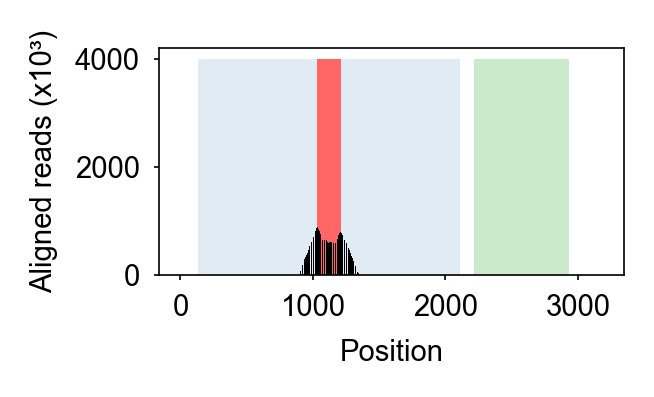

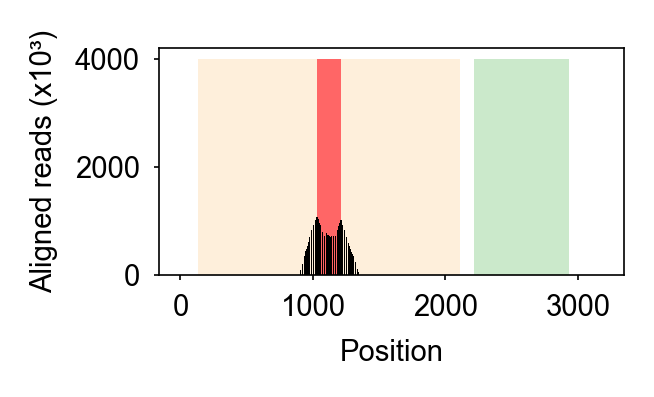

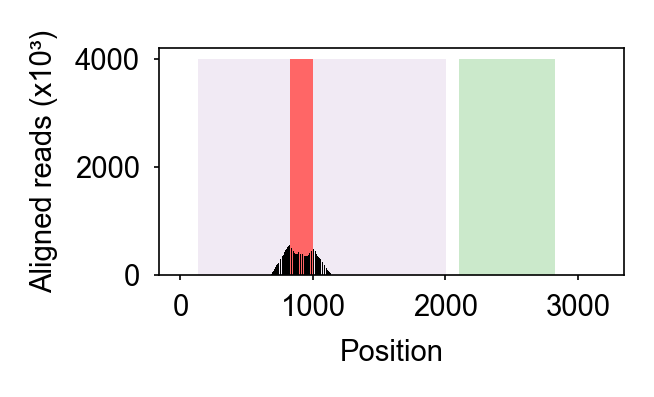

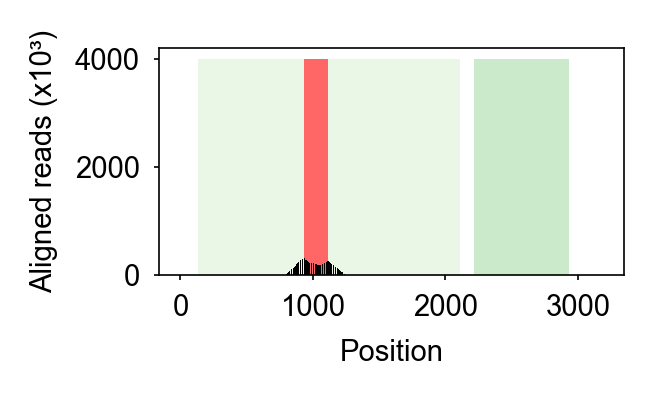

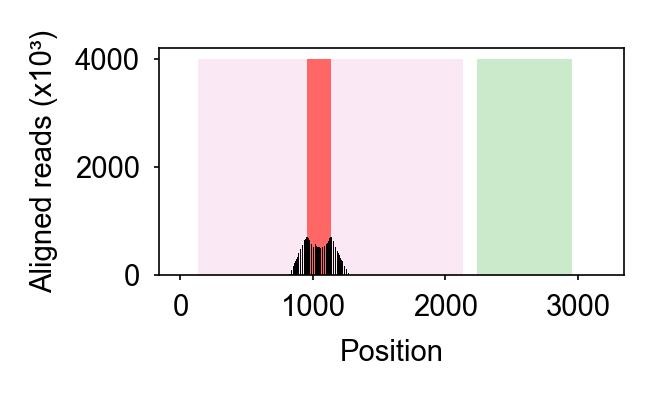

POS


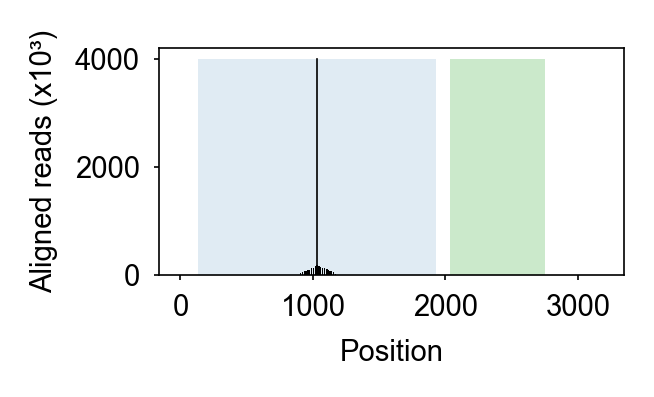

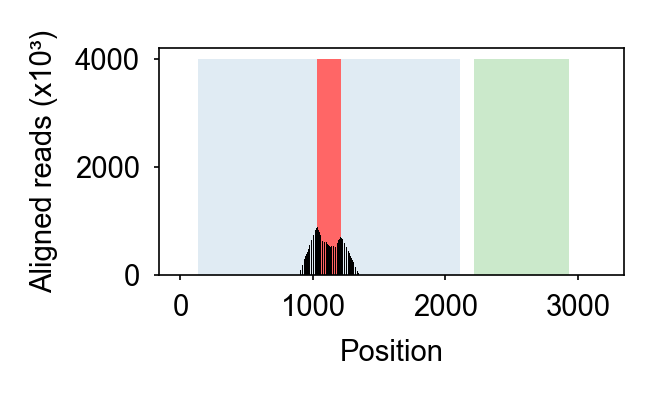

POS


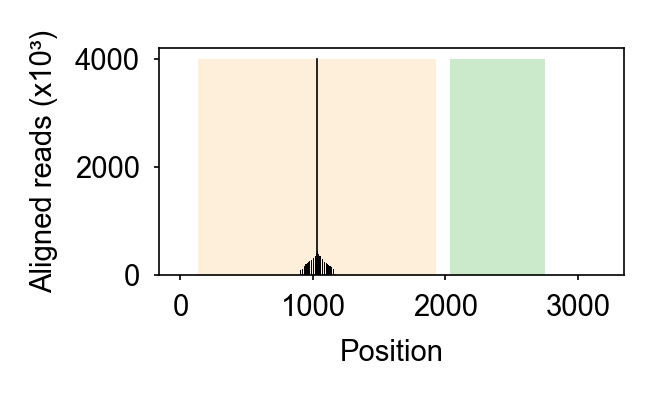

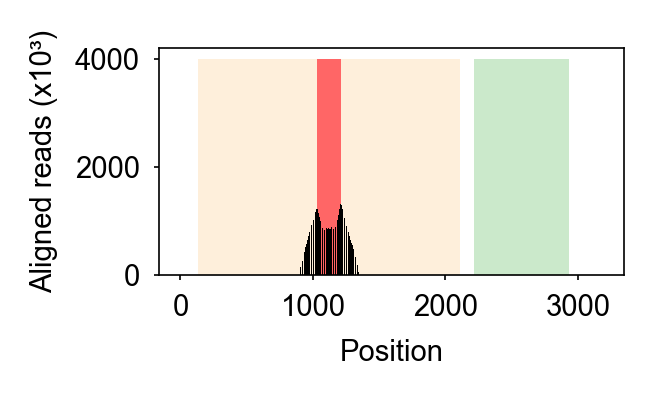

POS


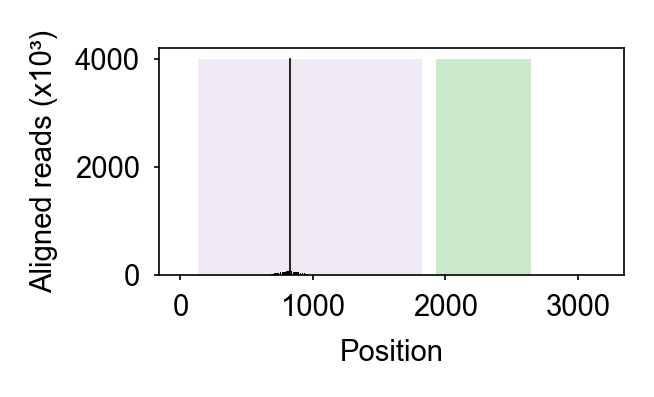

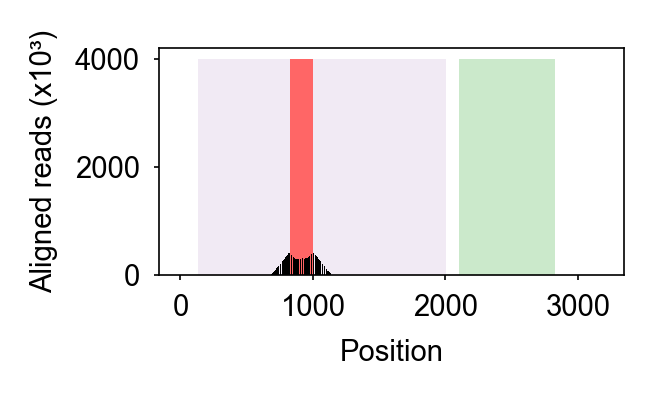

POS


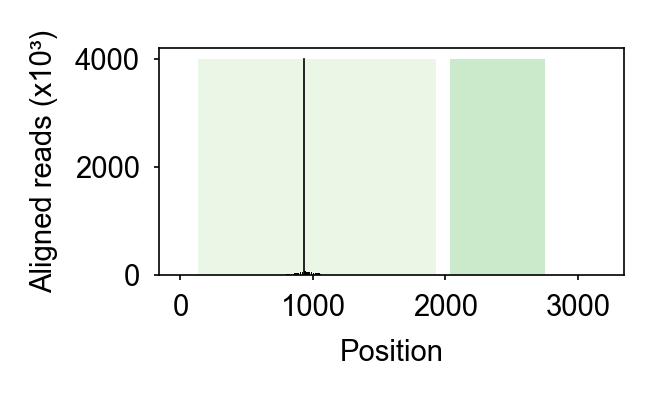

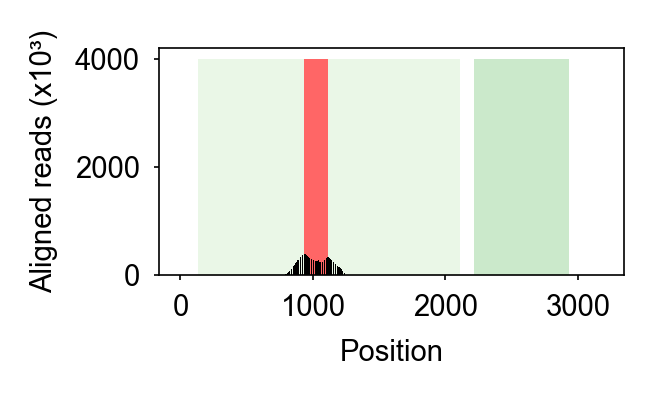

POS


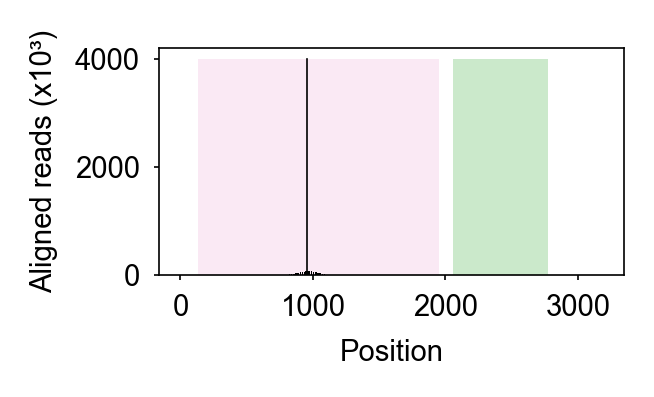

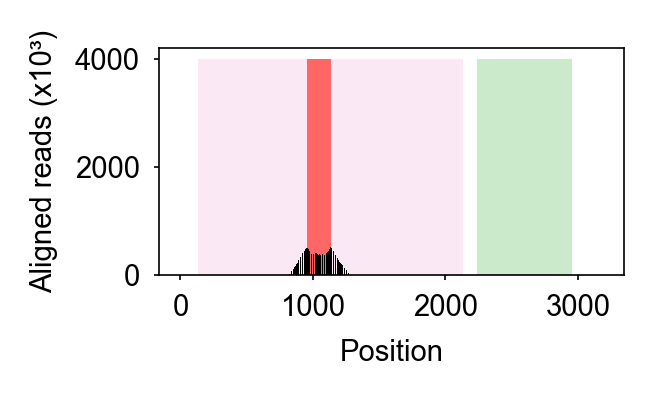

A


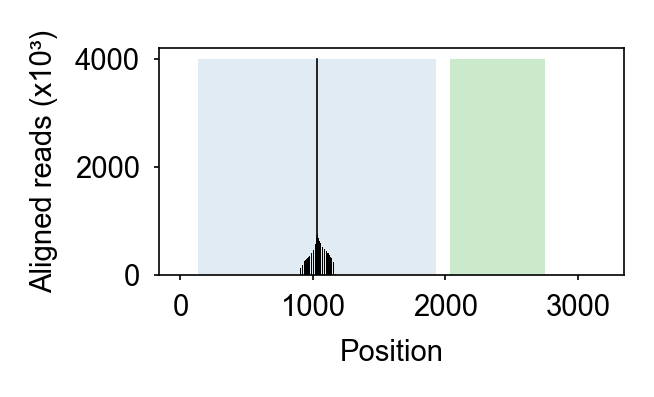

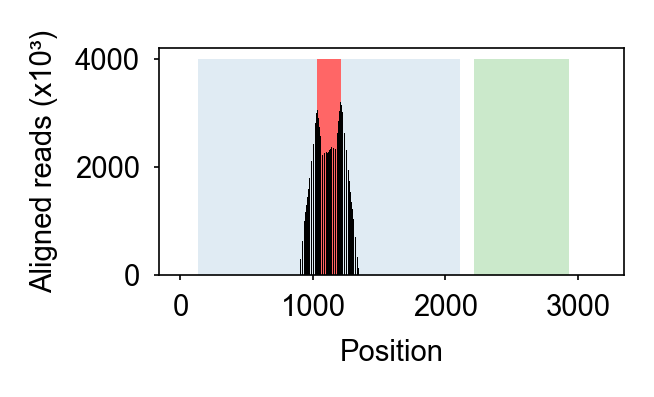

C


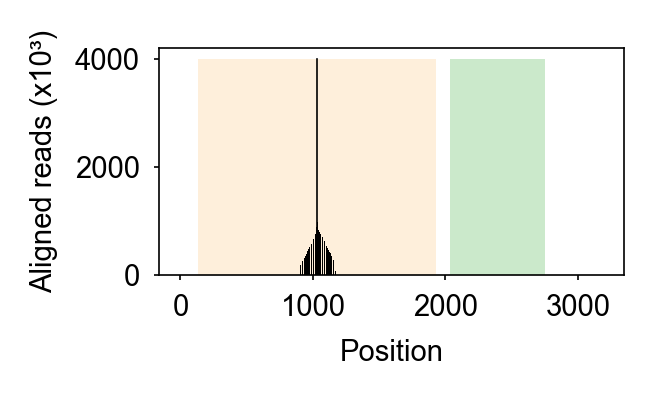

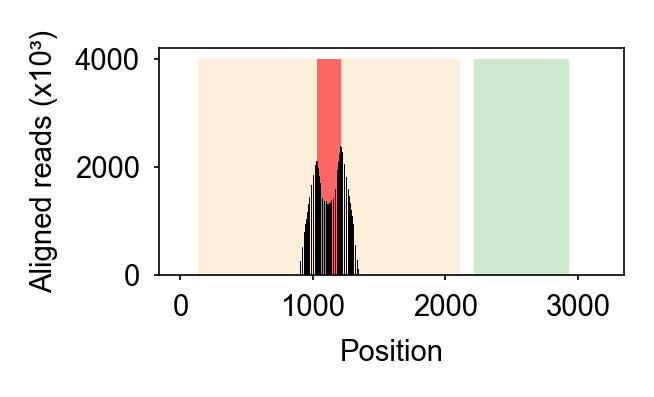

D


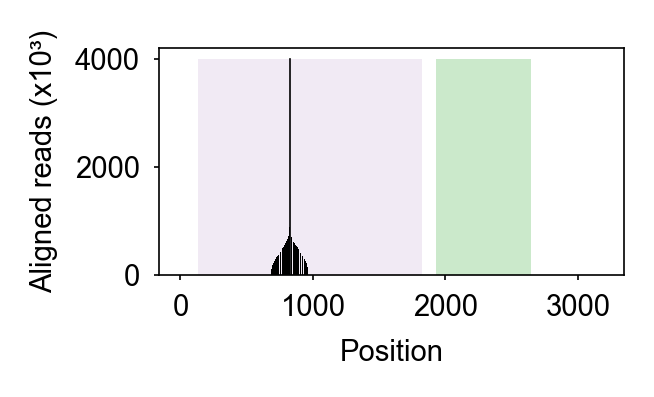

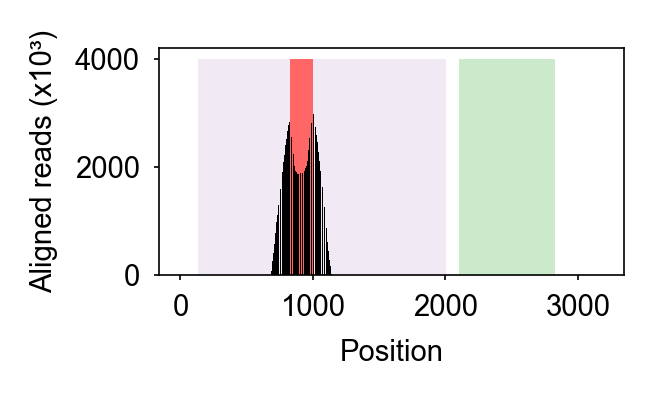

E


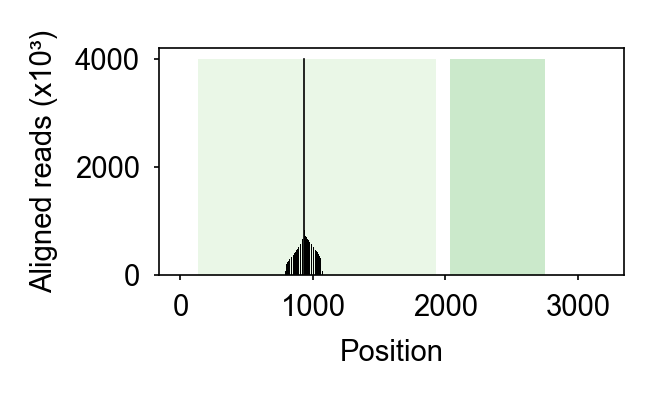

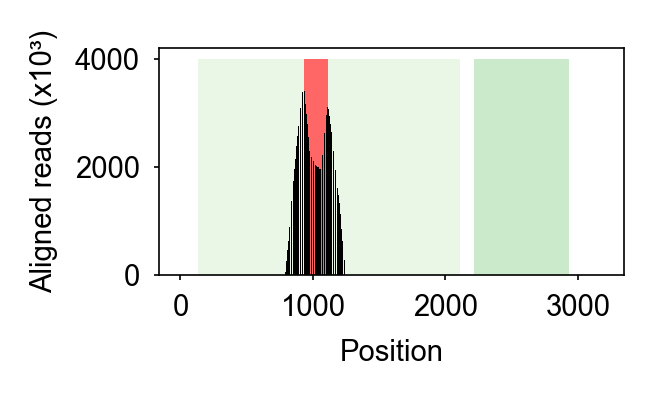

F


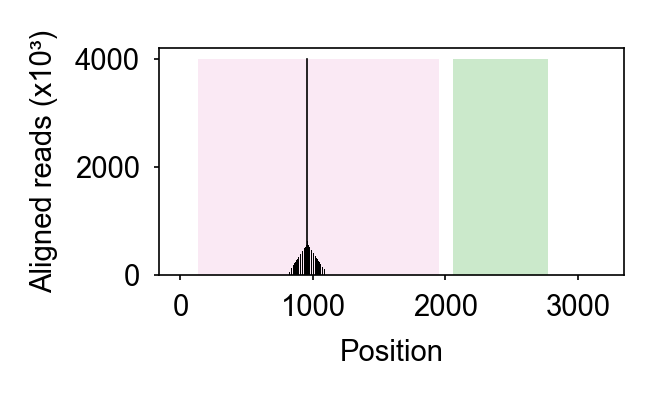

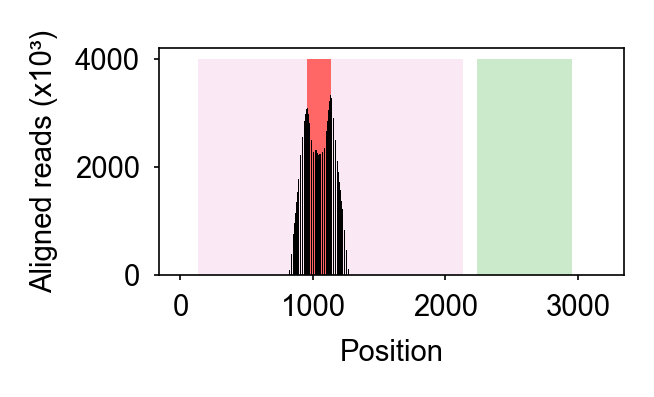

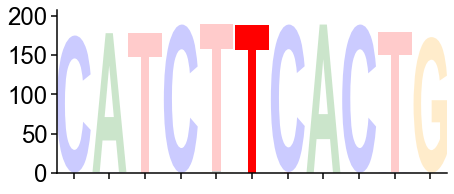

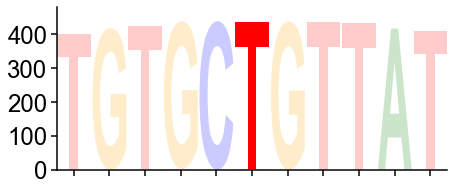

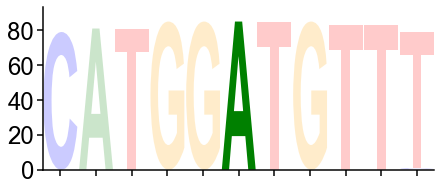

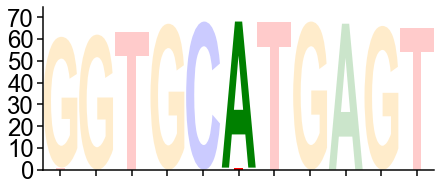

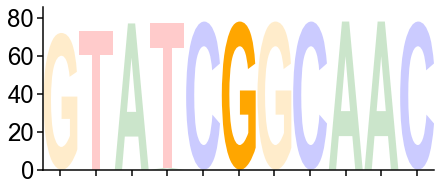

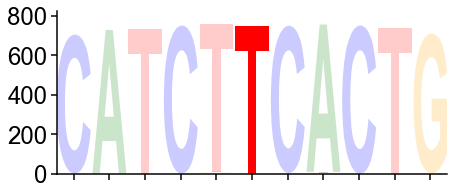

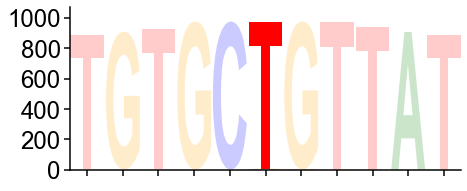

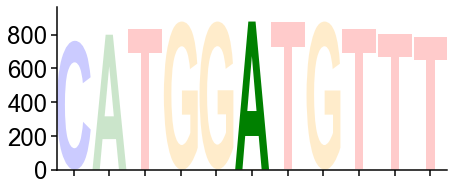

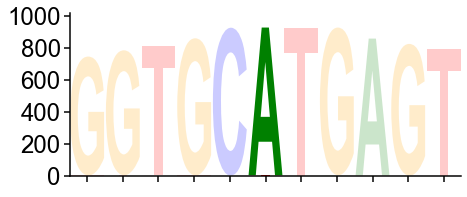

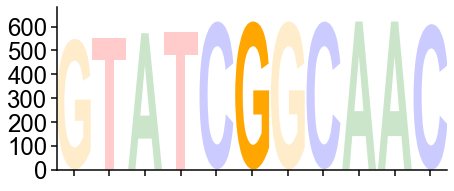

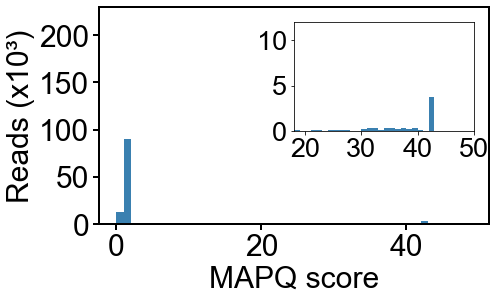

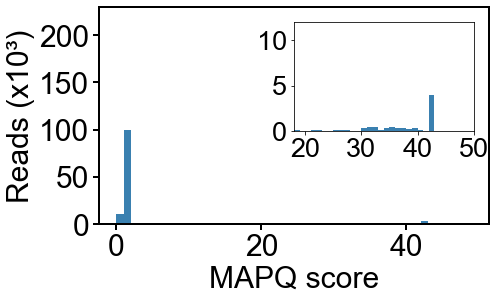

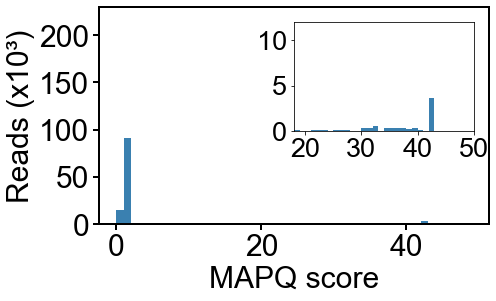

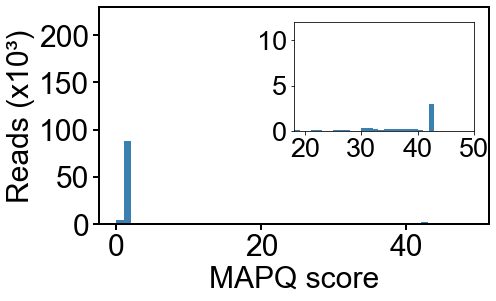

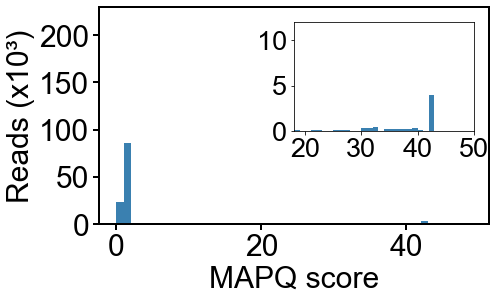

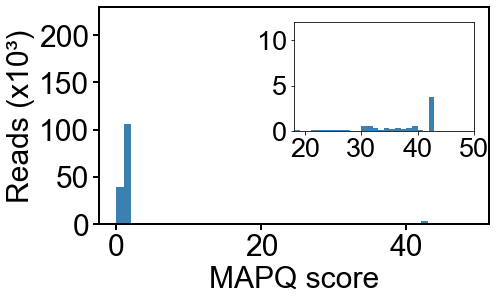

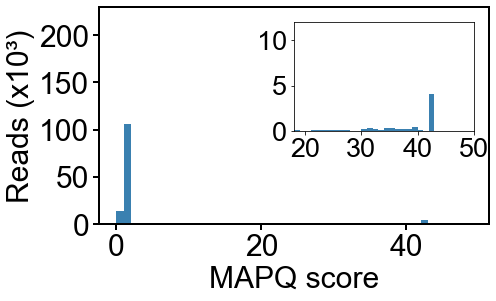

sample: NEG
A ON
0
A OFF
842.0
C ON
0
C OFF
1043.0
D ON
0
D OFF
508.0
E ON
0
E OFF
279.0
F ON
0
F OFF
705.0
sample: POS
A ON
189.0
A OFF
792.5
C ON
438.0
C OFF
1259.5
D ON
85.0
D OFF
406.5
E ON
68.0
E OFF
363.5
F ON
78.0
F OFF
498.0
sample: A
A ON
751.0
A OFF
3134.0
C ON
0
C OFF
0
D ON
0
D OFF
0
E ON
0
E OFF
0
F ON
0
F OFF
0
sample: C
A ON
0
A OFF
0
C ON
976.0
C OFF
2250.5
D ON
0
D OFF
0
E ON
0
E OFF
0
F ON
0
F OFF
0
sample: D
A ON
0
A OFF
0
C ON
0
C OFF
0
D ON
878.0
D OFF
2907.0
E ON
0
E OFF
0
F ON
0
F OFF
0
sample: E
A ON
0
A OFF
0
C ON
0
C OFF
0
D ON
0
D OFF
0
E ON
925.0
E OFF
3297.0
F ON
0
F OFF
0
sample: F
A ON
0
A OFF
0
C ON
0
C OFF
0
D ON
0
D OFF
0
E ON
0
E OFF
0
F ON
621.0
F OFF
3215.5


In [26]:
#processing SAM file to generate figures

#replicate 1

files=glob.glob('NGS_fig5_rep1/*.sam')
# for f in files:
#     print(f + '/n')
    
profiles={}
seqs={}
quals={}
mapqs={}

samples=['NEG', 'POS', 'A', 'C', 'D', 'E', 'F']
# 'NEG' is all cells - DNA, 'POS' is all cells + all DNA
# 'A' is SEN1 cells only + all DNAs
# 'C' is SEN2 cells only + all DNAs
# 'D' is SEN3 cells only + all DNAs
# 'E' is SEN4 cells only + all DNAs
# 'F' is SEN5 cells only + all DNAs

#import files
for sample in samples:
    f='NGS_fig5_rep1/' + sample + '_s_5_18.sam'
    profiles[sample], seqs[sample], quals[sample], mapqs[sample]= read_sam_file2(f)
    
#plot profiles
for sample in samples:
    for key, color in zip(['A', 'C', 'D', 'E', 'F'], pastels):
        if key in profiles[sample].keys():
            print(sample)
            plot_ON_profile(profiles[sample], key, color, sample+'_'+key)
        if key+'_term' in profiles[sample].keys():
            plot_OFF_profile(profiles[sample], key, color, sample+'_'+key)

fs=30
w=.5
x=7*w
ms=7
lw=2
# plot logos
for sample in samples: 
    for key in ['A', 'C', 'D', 'E', 'F']:
        if key in profiles[sample].keys():
            fig, ax=plt.subplots(figsize=(7, 3))
            plot_logo(seqs[sample][key], SNP_loc[key], 5, ax, 1.1*profiles[sample][key][SNP_loc[key]])
            plt.show()
            plt.tight_layout()
#             fig.savefig(output + '/logo_' + sample+ '_' + key+'_630.pdf', bbox_inches='tight')
            plt.close()

#plot MAPQ scores
for sample in samples:
    plot_mapq(mapqs[sample], 'mapq_'+sample)


#calculate read counts
for sample in samples:
    print('sample: '+sample)
    get_read_counts(profiles[sample], darks, pastels, sample)


{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['A_term', 'D_term', 'E_term', 'C_term', 'F_term'])
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['A_term', 'F_term', 'E_term', 'D_term', 'A', 'C', 'F', 'D', 'C_term', 'E'])
N: no value assigned
N: no value assigned
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['A_term', 'A'])
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['C', 'C_term'])
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['D_term', 'D', 'A_term'])
N: no value assigned
N: no value assig

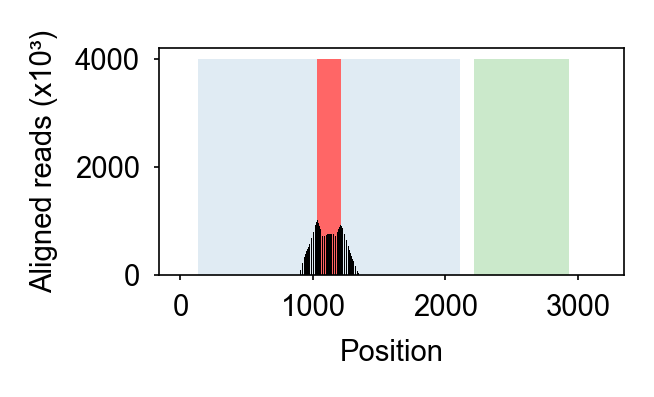

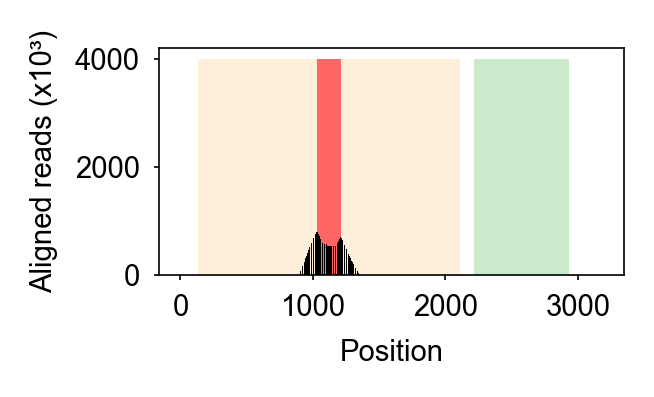

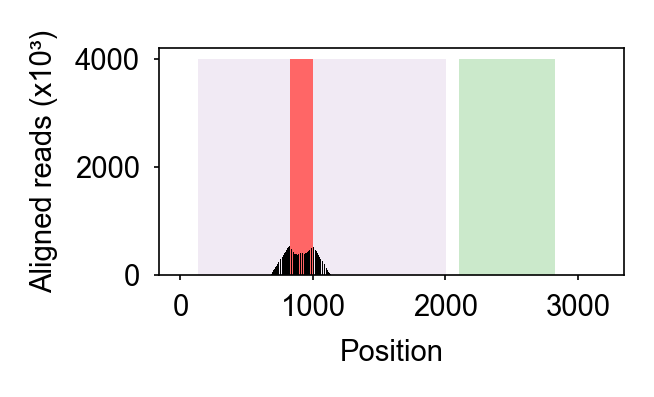

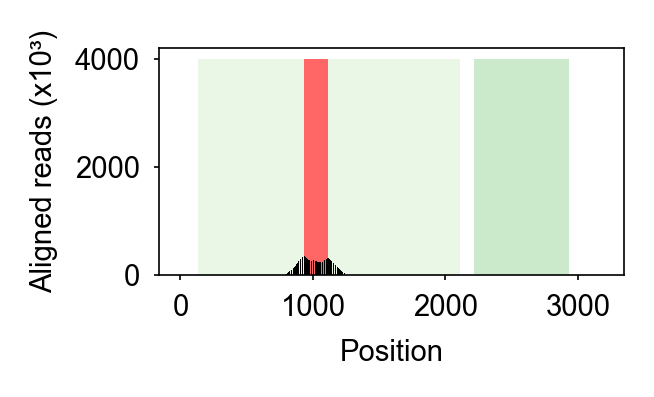

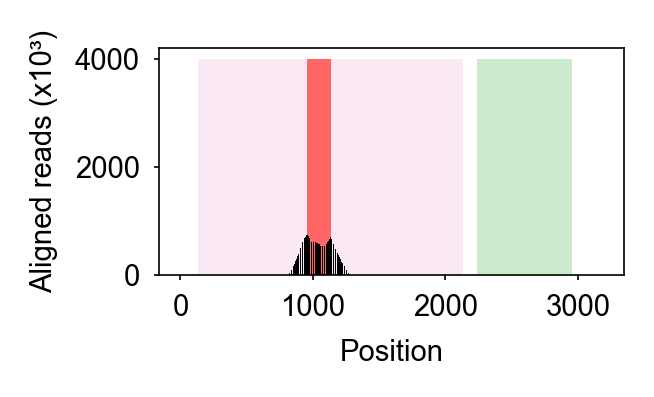

POS


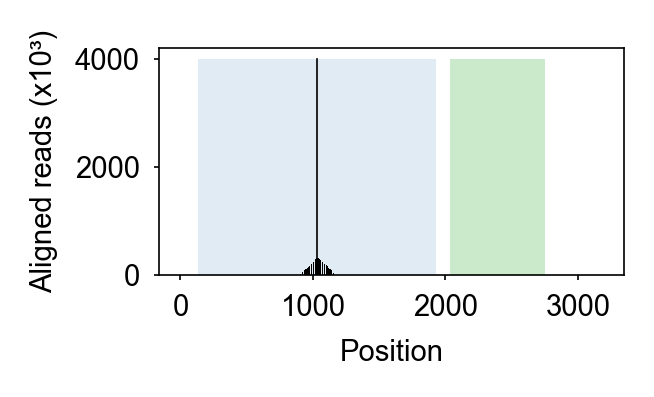

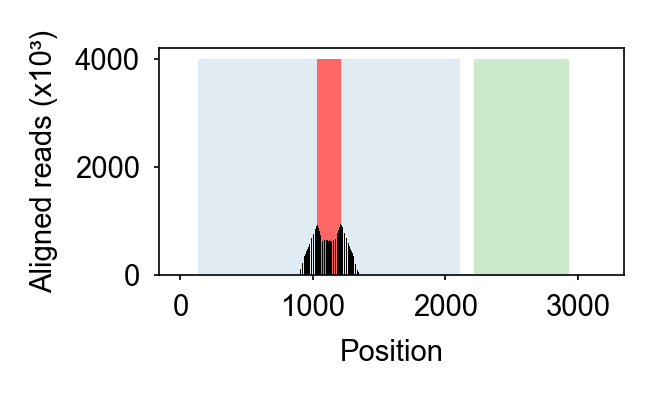

POS


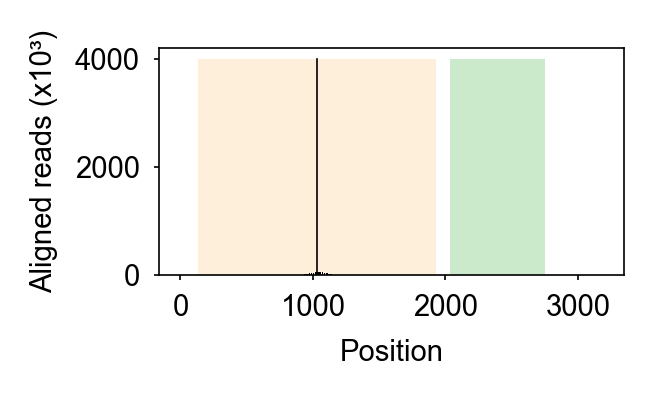

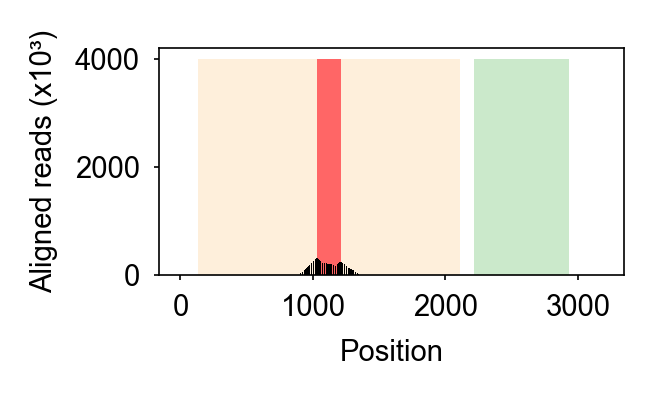

POS


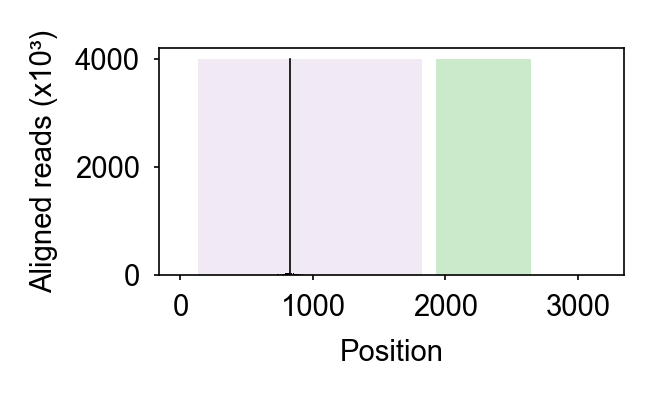

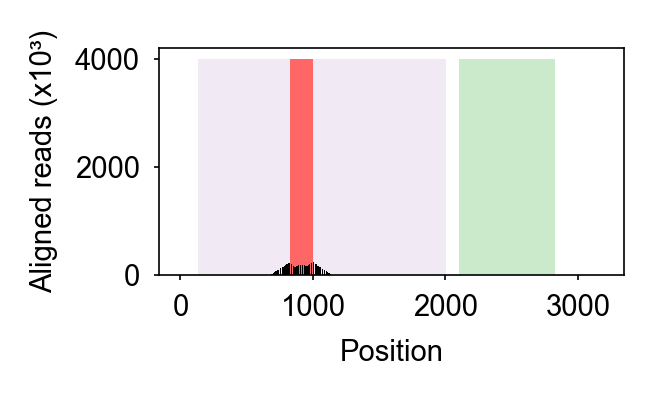

POS


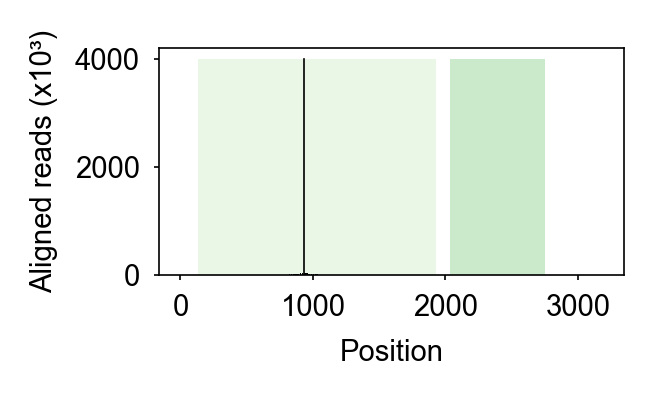

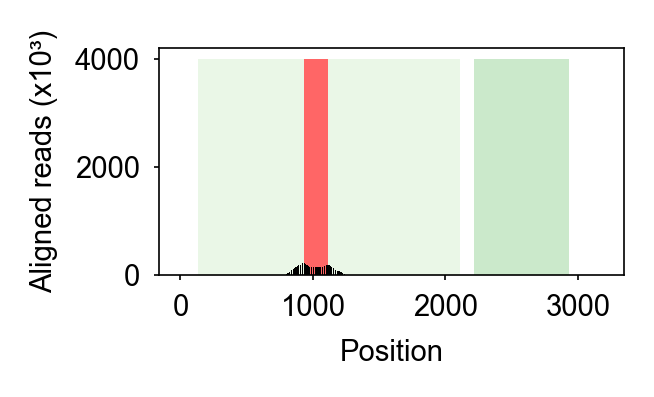

POS


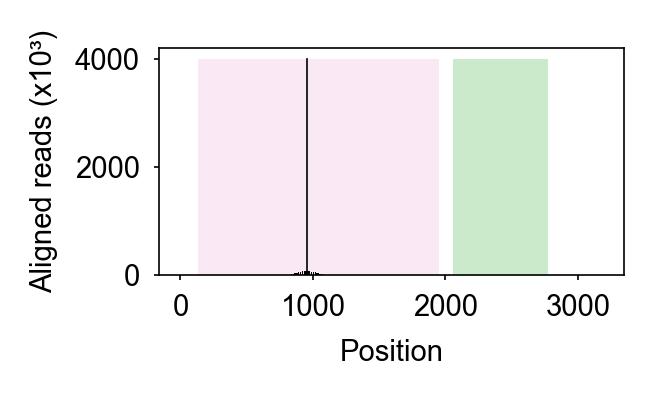

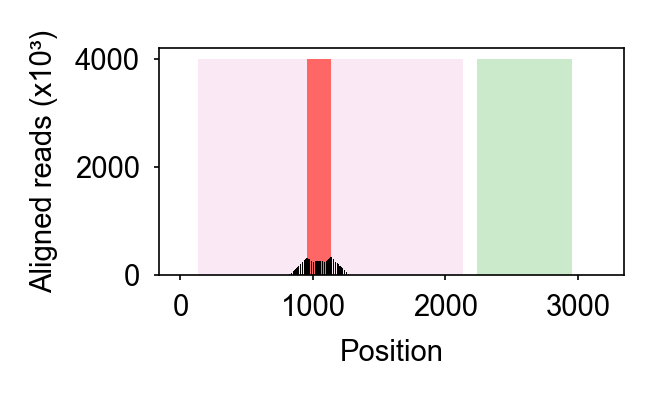

A


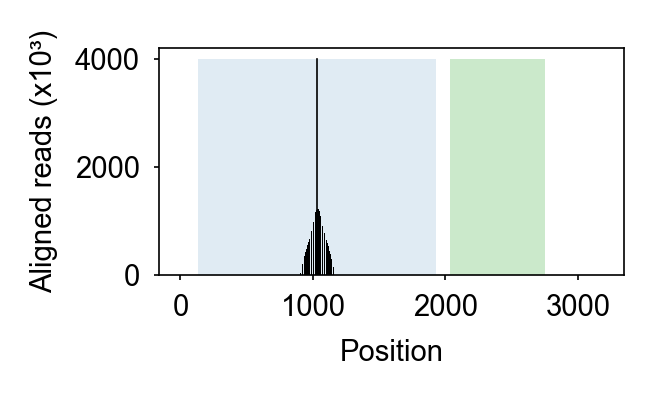

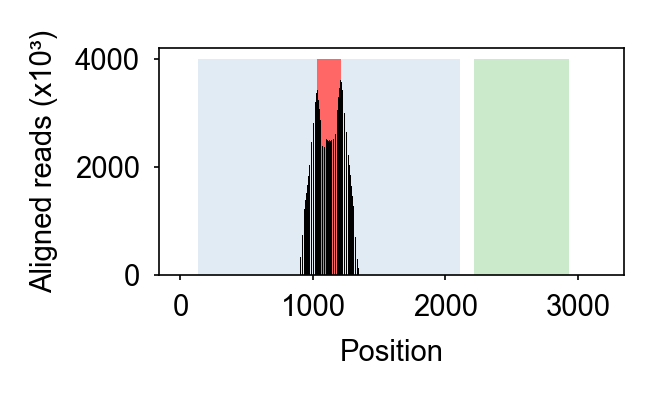

C


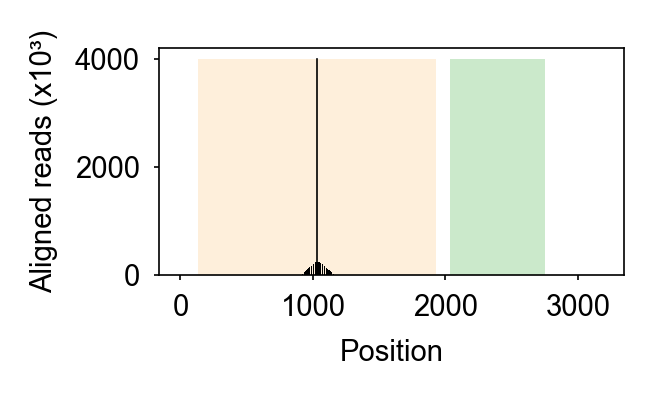

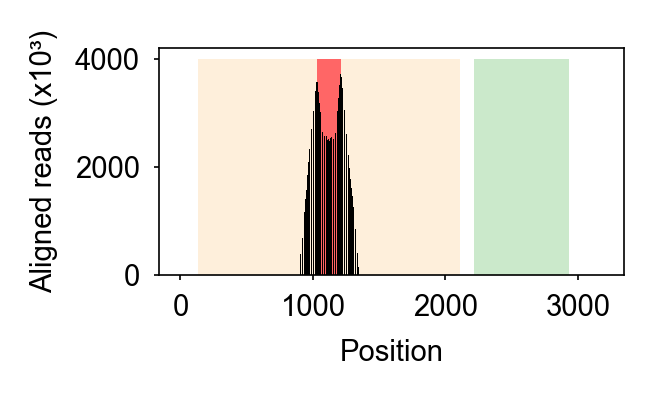

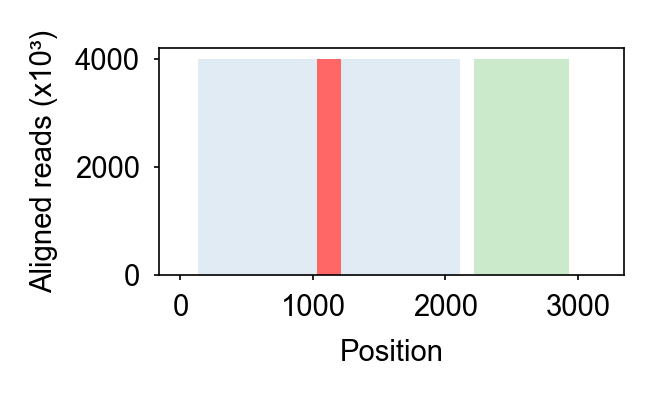

D


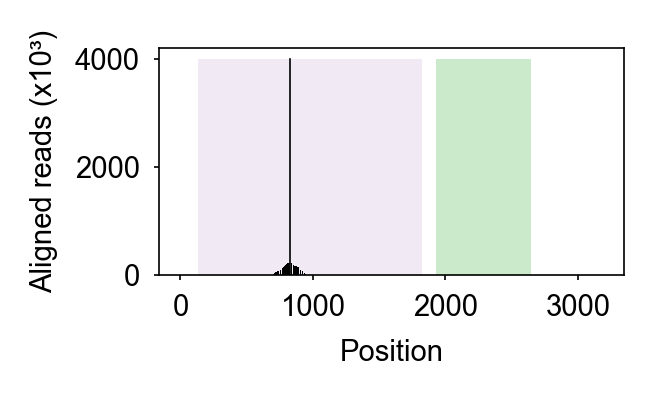

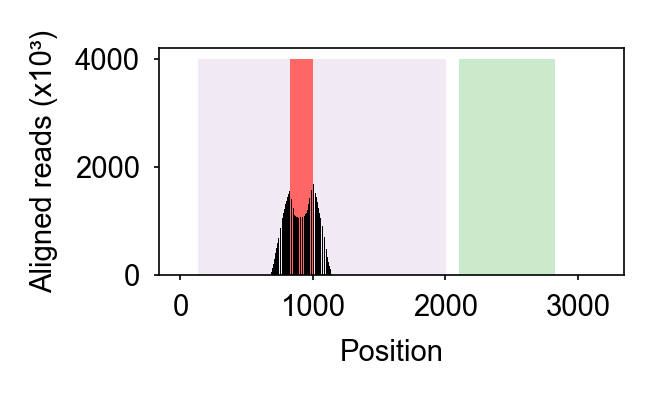

E


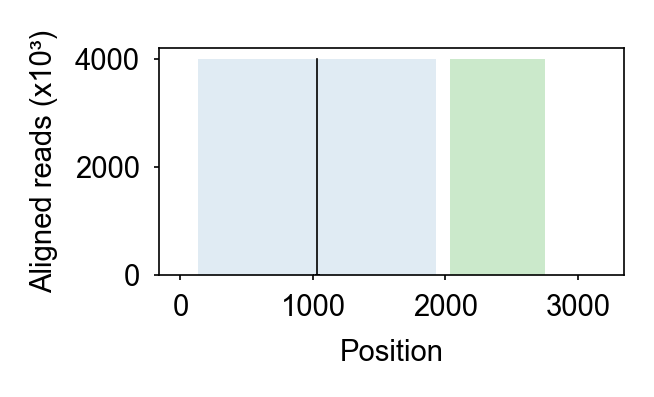

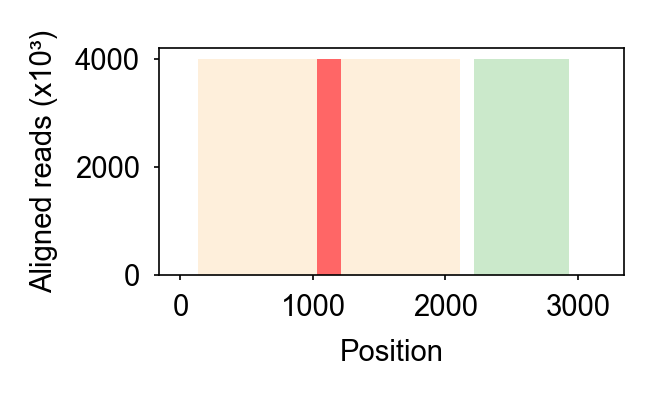

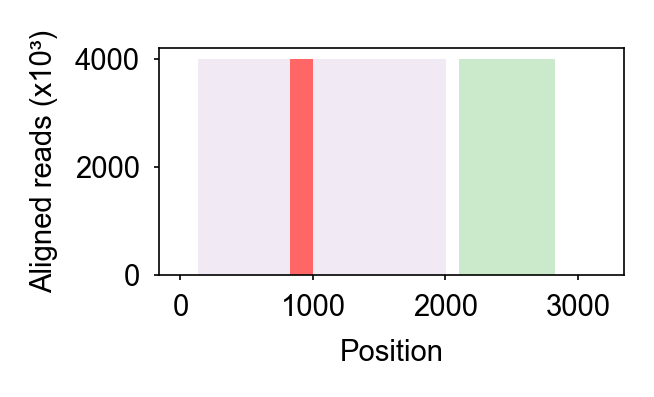

E


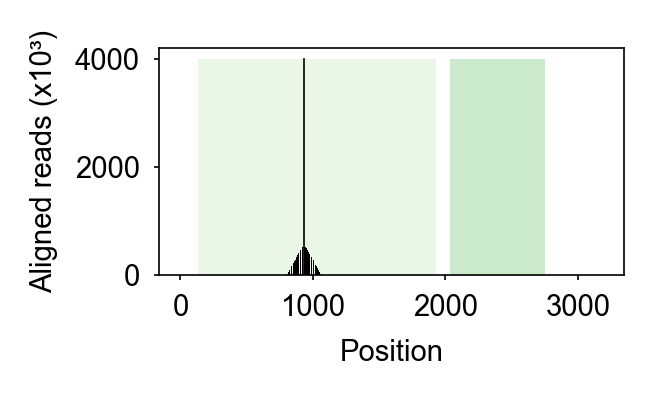

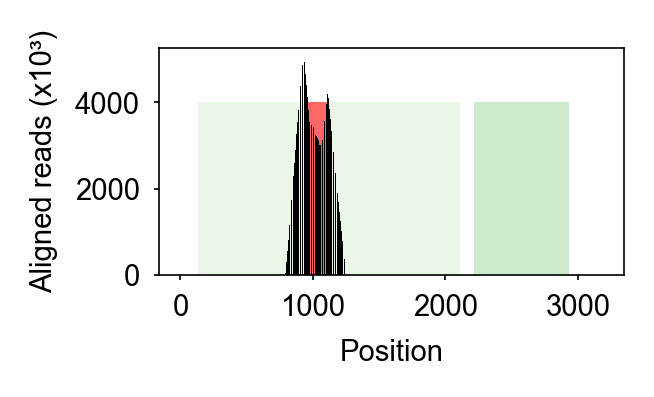

F


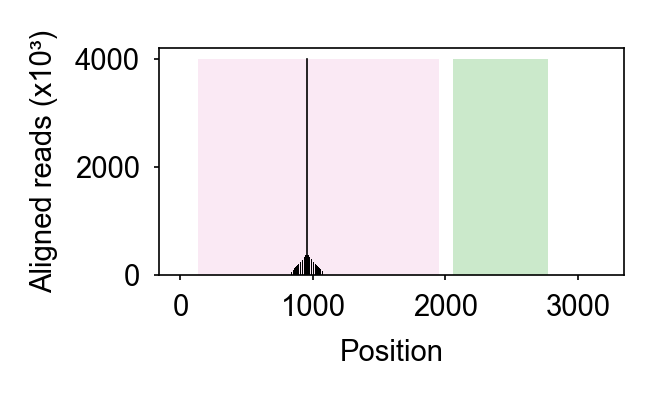

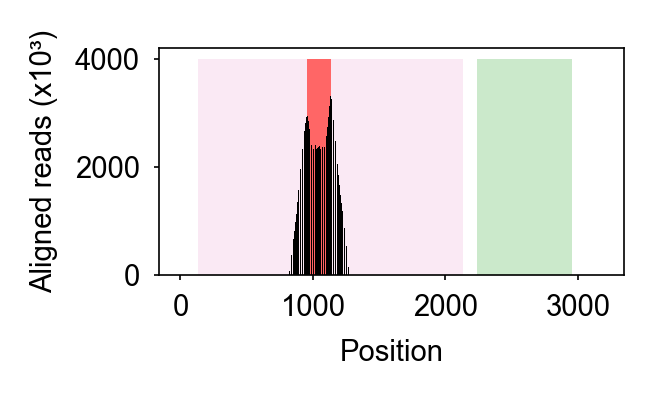

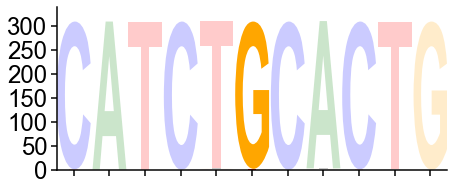

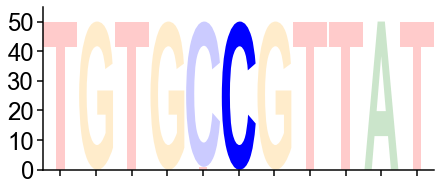

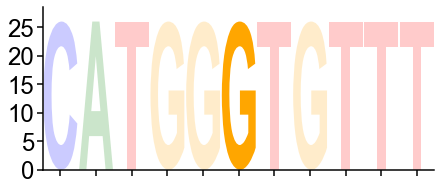

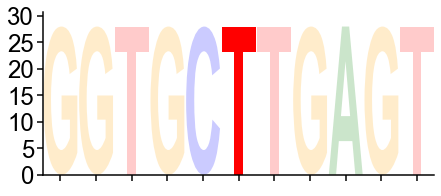

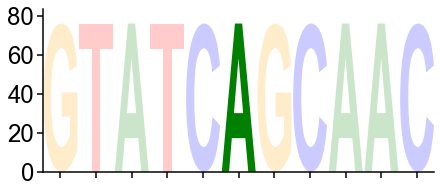

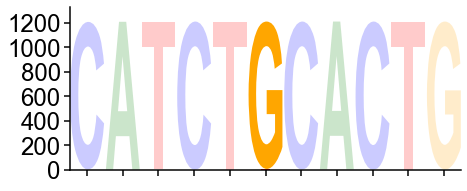

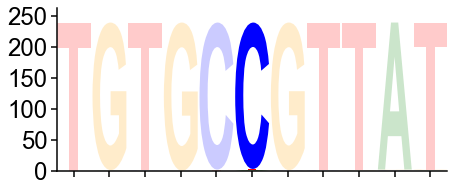

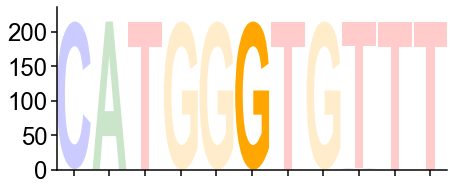

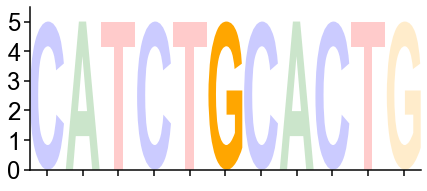

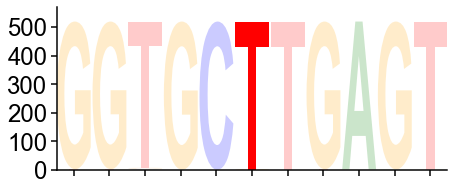

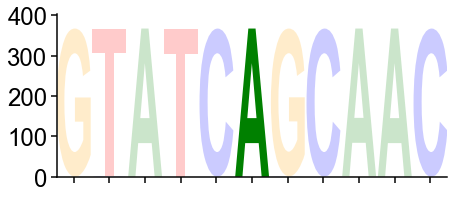

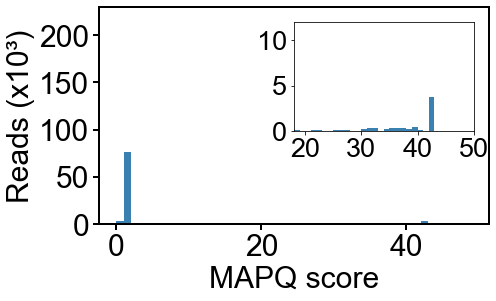

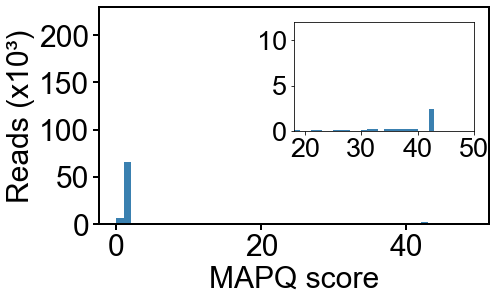

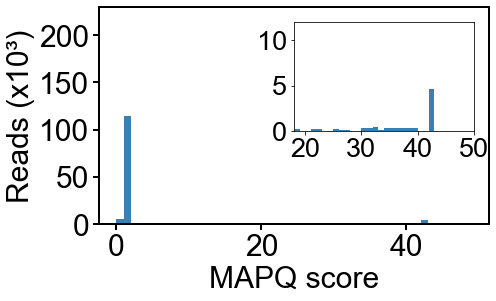

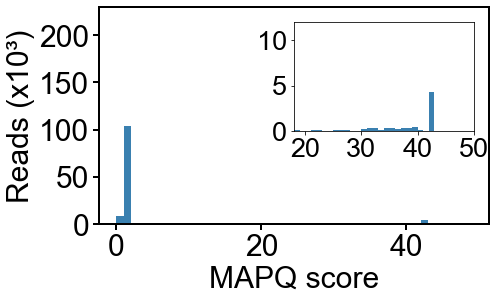

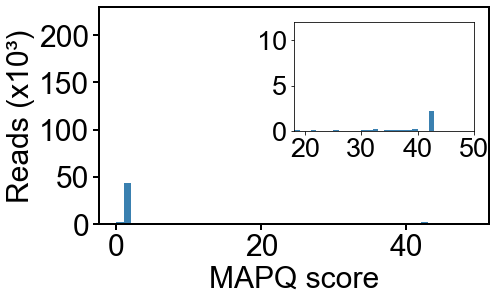

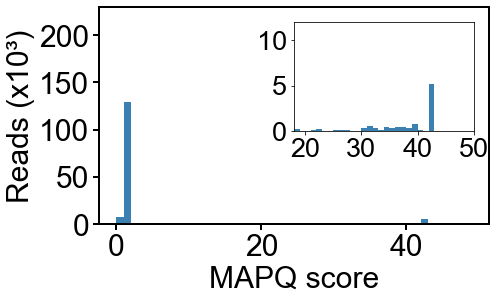

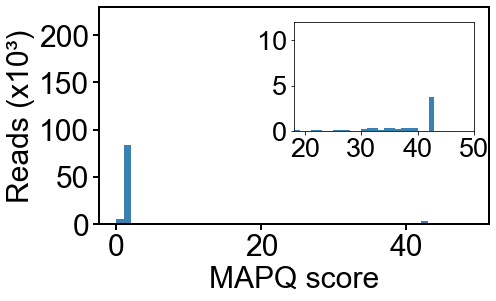

sample: NEG
A ON
0
A OFF
966.0
C ON
0
C OFF
747.5
D ON
0
D OFF
524.5
E ON
0
E OFF
328.5
F ON
0
F OFF
717.0
sample: POS
A ON
309.0
A OFF
931.0
C ON
50.0
C OFF
271.5
D ON
26.0
D OFF
228.5
E ON
28.0
E OFF
205.0
F ON
76.0
F OFF
326.5
sample: A
A ON
1212.0
A OFF
3525.5
C ON
0
C OFF
0
D ON
0
D OFF
0
E ON
0
E OFF
0
F ON
0
F OFF
0
sample: C
A ON
0
A OFF
0
C ON
239.0
C OFF
3652.5
D ON
0
D OFF
0
E ON
0
E OFF
0
F ON
0
F OFF
0
sample: D
A ON
0
A OFF
0.5
C ON
0
C OFF
0
D ON
215.0
D OFF
1610.0
E ON
0
E OFF
0
F ON
0
F OFF
0
sample: E
A ON
5.0
A OFF
0
C ON
0
C OFF
1.5
D ON
0
D OFF
1.5
E ON
519.0
E OFF
4597.0
F ON
0
F OFF
0
sample: F
A ON
0
A OFF
0
C ON
0
C OFF
0
D ON
0
D OFF
0
E ON
0
E OFF
0
F ON
367.0
F OFF
3129.5


In [24]:
#replicate 2

files=glob.glob('NGS_fig5_rep2/*.sam')
# for f in files:
#     print(f + '/n')
    
profiles={}
seqs={}
quals={}
mapqs={}

samples=['NEG', 'POS', 'A', 'C', 'D', 'E', 'F']
# 'NEG' is all cells - DNA, 'POS' is all cells + all DNA
# 'A' is SEN1 cells only + all DNAs
# 'C' is SEN2 cells only + all DNAs
# 'D' is SEN3 cells only + all DNAs
# 'E' is SEN4 cells only + all DNAs
# 'F' is SEN5 cells only + all DNAs

#import files
for sample in samples:
    f='NGS_fig5_rep2/' + sample + '.sam'
    profiles[sample], seqs[sample], quals[sample], mapqs[sample]= read_sam_file2(f)
    
#plot profiles
for sample in samples:
    for key, color in zip(['A', 'C', 'D', 'E', 'F'], pastels):
        if key in profiles[sample].keys():
            print(sample)
            plot_ON_profile(profiles[sample], key, color, sample+'_'+key)
        if key+'_term' in profiles[sample].keys():
            plot_OFF_profile(profiles[sample], key, color, sample+'_'+key)

fs=30
w=.5
x=7*w
ms=7
lw=2
# plot logos
for sample in samples: 
    for key in ['A', 'C', 'D', 'E', 'F']:
        if key in profiles[sample].keys():
            fig, ax=plt.subplots(figsize=(7, 3))
            plot_logo(seqs[sample][key], SNP_loc[key], 5, ax, 1.1*profiles[sample][key][SNP_loc[key]])
            plt.show()
            plt.tight_layout()
#             fig.savefig(output + '/logo_' + sample+ '_' + key+'_630.pdf', bbox_inches='tight')
            plt.close()

#plot MAPQ scores
for sample in samples:
    plot_mapq(mapqs[sample], 'mapq_'+sample)


#calculate read counts
for sample in samples:
    print('sample: '+sample)
    get_read_counts(profiles[sample], darks, pastels, sample)


{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['A_term', 'D_term', 'C_term', 'E_term', 'F_term'])
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['E_term', 'C_term', 'A_term', 'D_term', 'F_term', 'D', 'A', 'C', 'F', 'E'])
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['A_term', 'A'])
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['C_term', 'C'])
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D_term': 3057, 'E_term': 3166, 'F_term': 3189}
dict_keys(['D_term', 'D'])
{'A': 2987, 'C': 2987, 'D': 2879, 'E': 2988, 'F': 3011, 'A_term': 3165, 'C_term': 3165, 'D

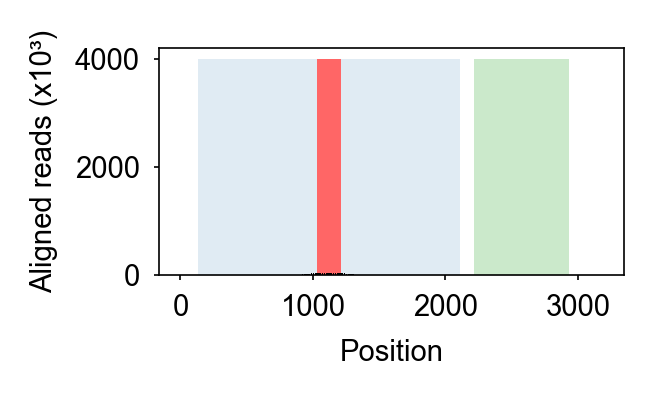

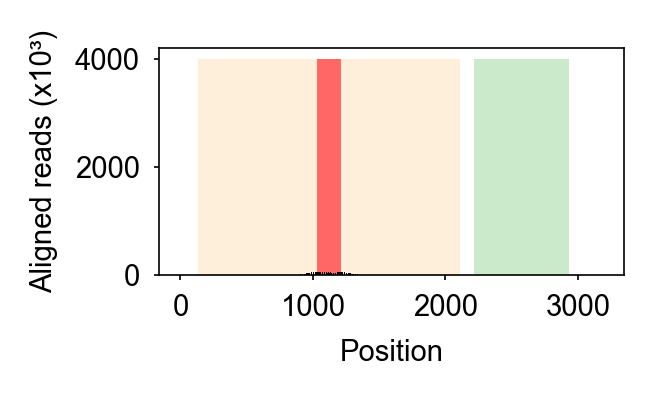

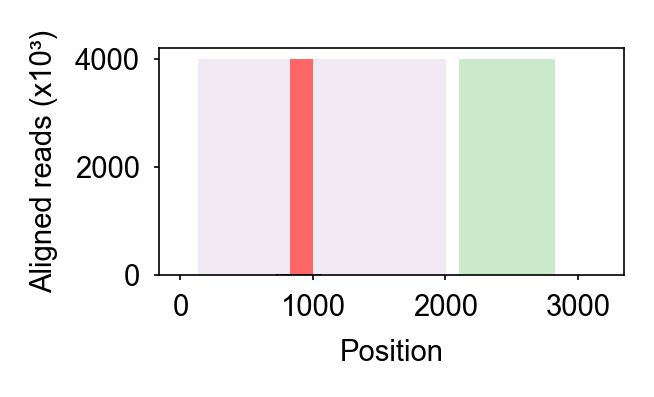

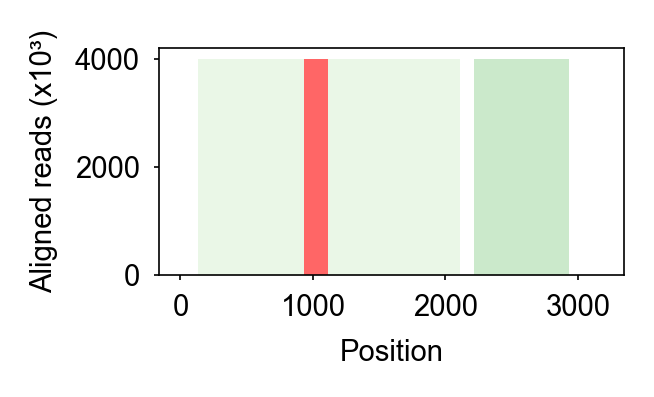

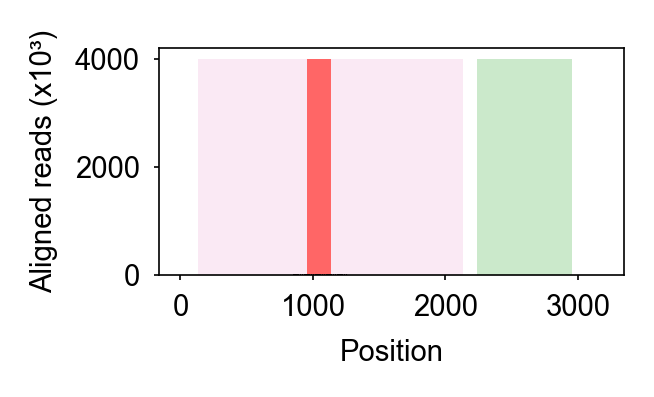

POS


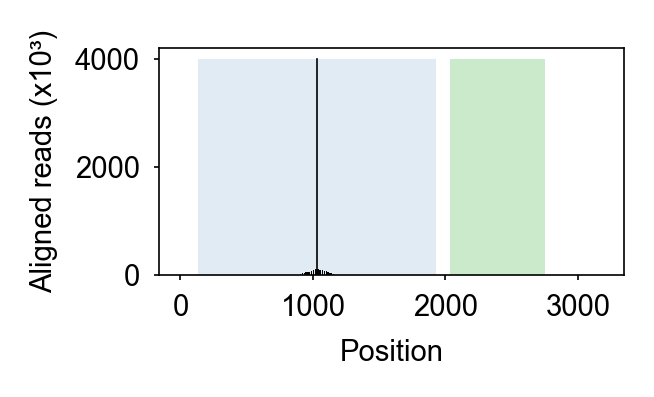

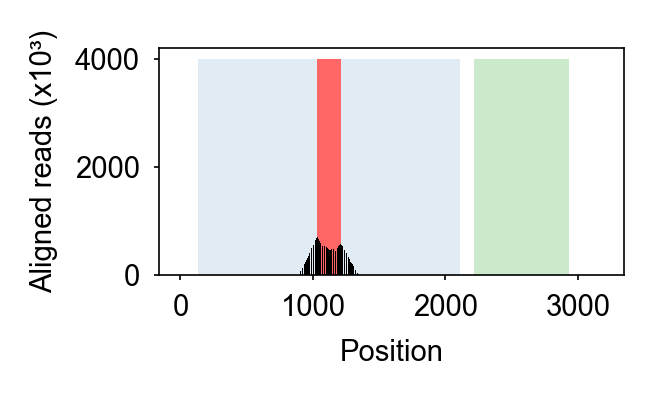

POS


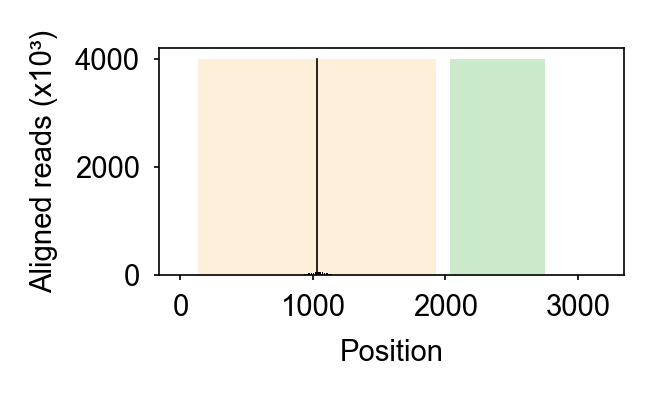

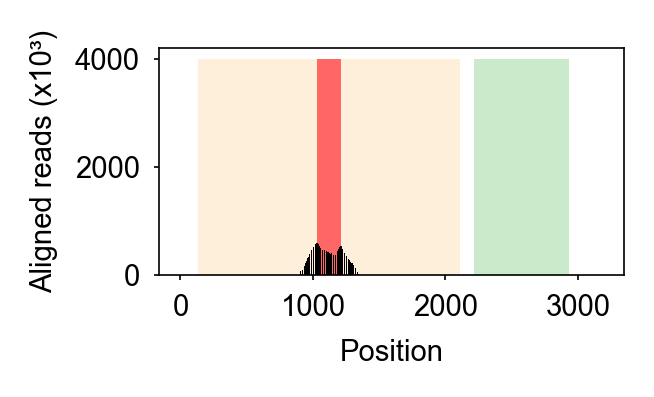

POS


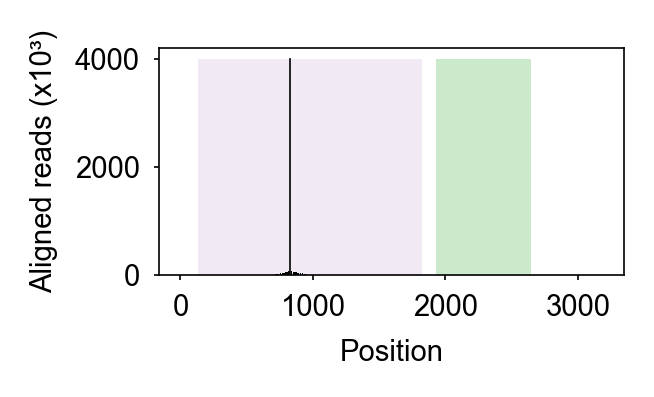

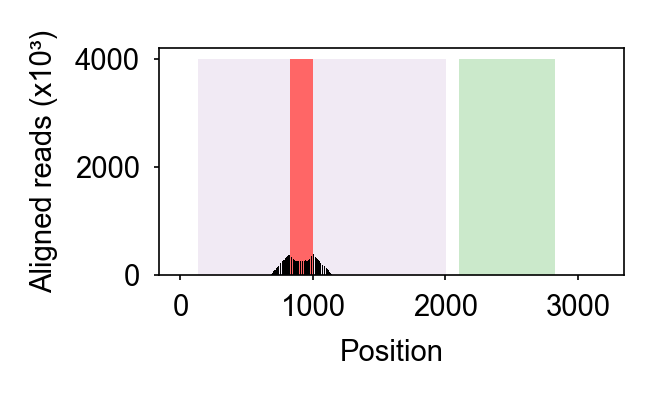

POS


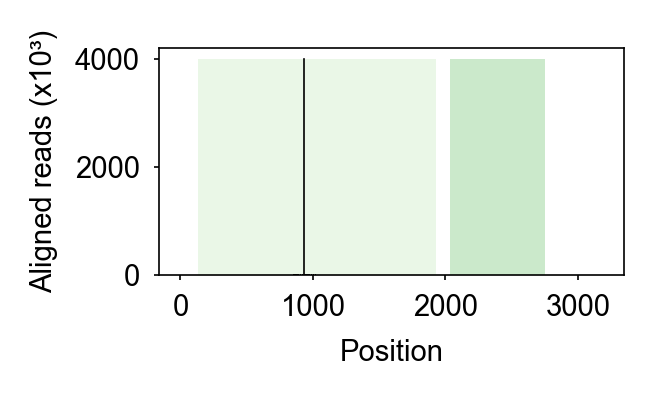

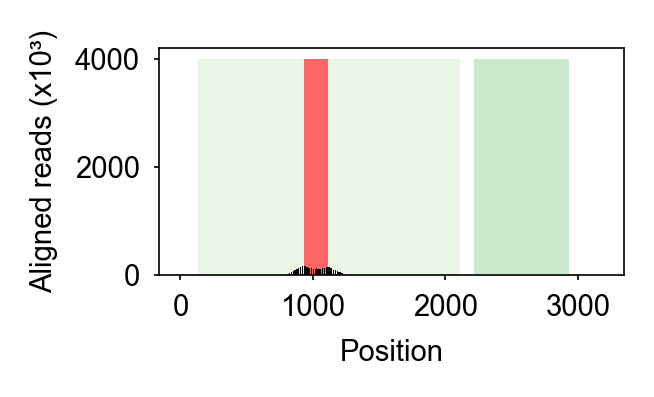

POS


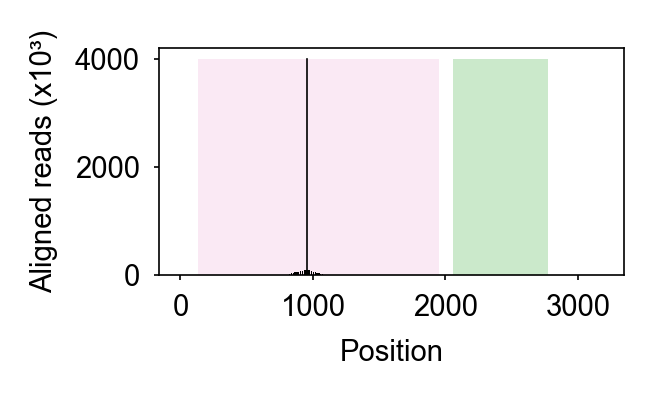

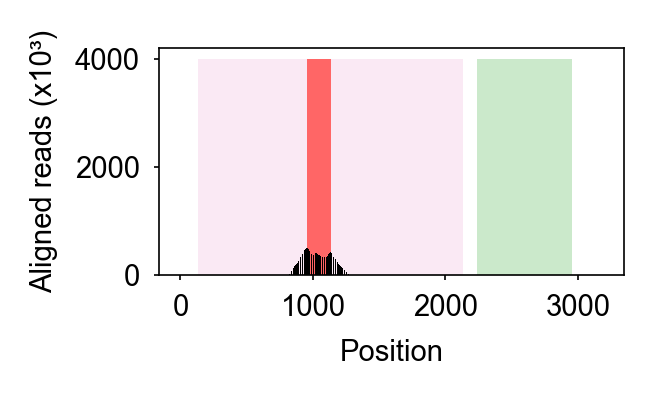

A


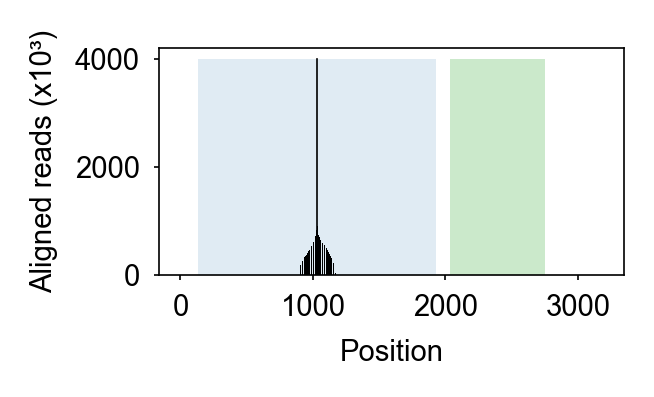

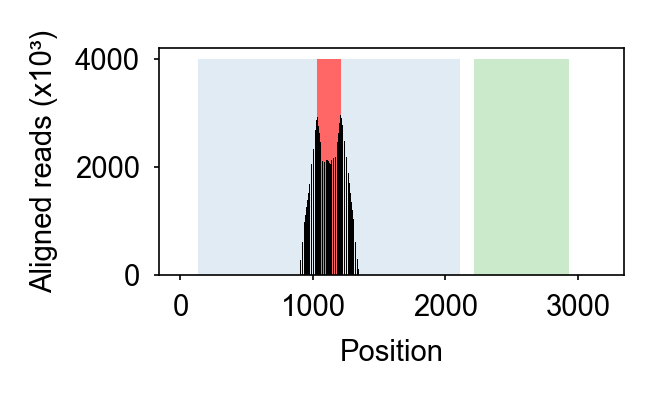

C


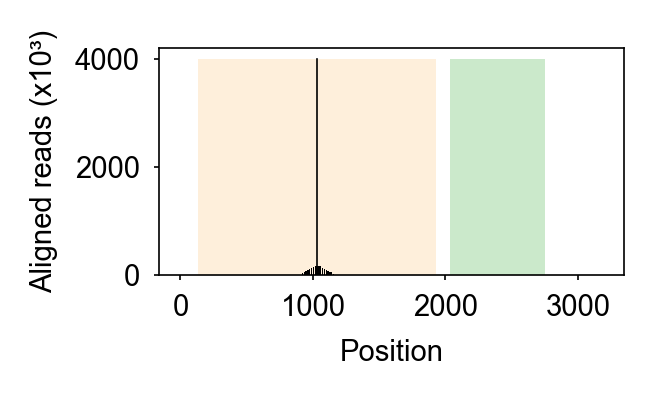

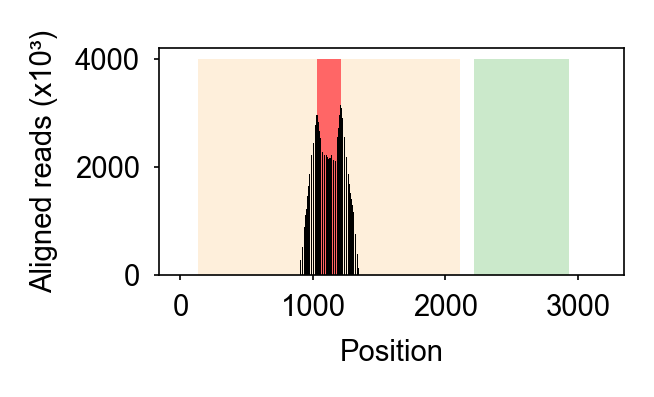

D


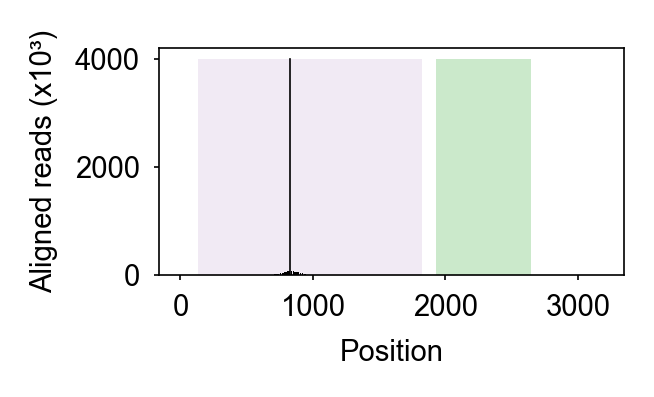

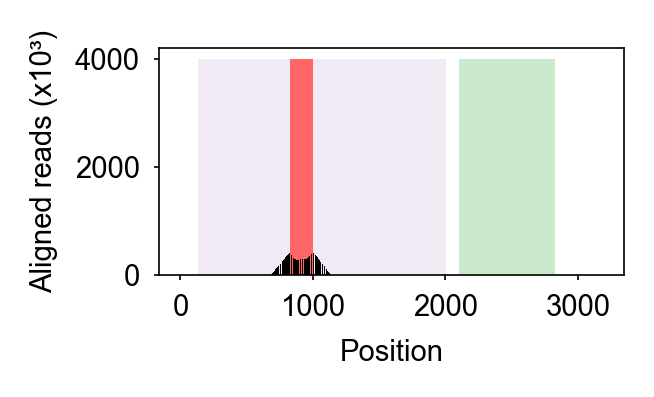

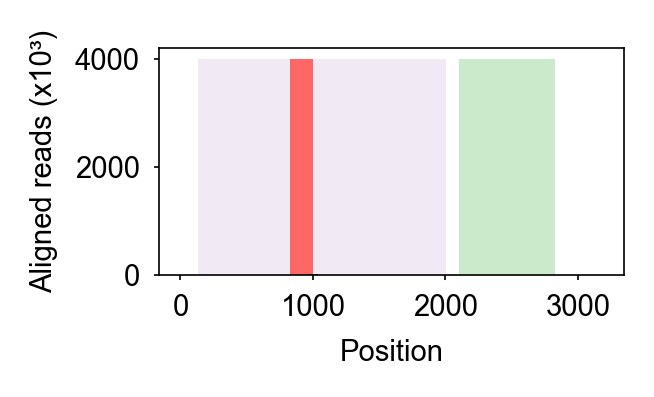

E


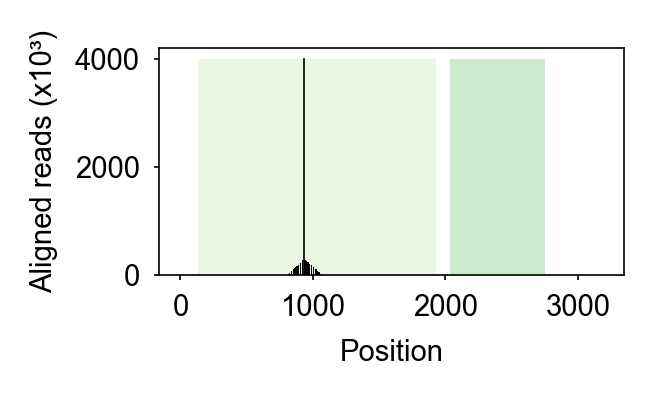

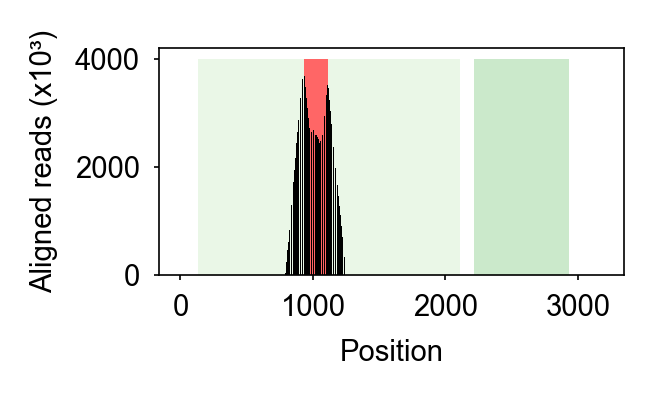

F


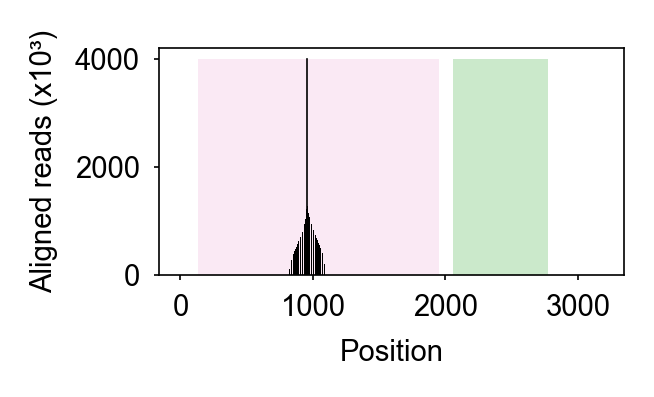

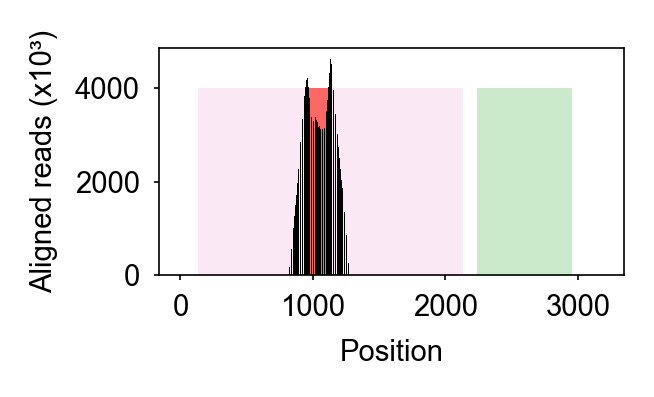

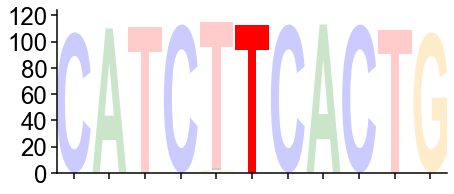

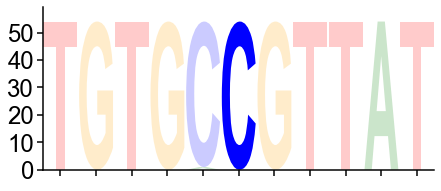

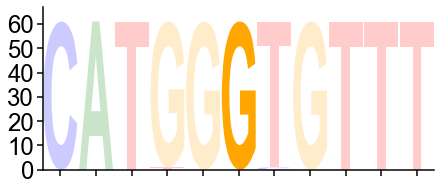

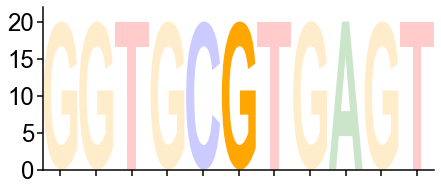

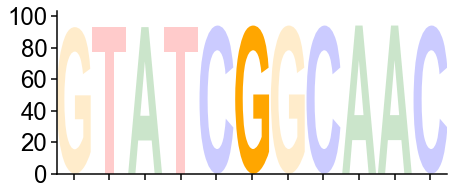

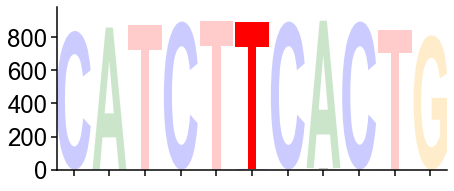

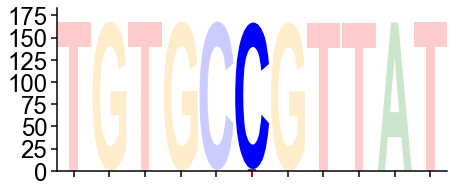

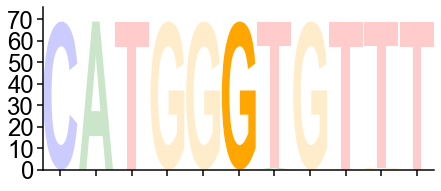

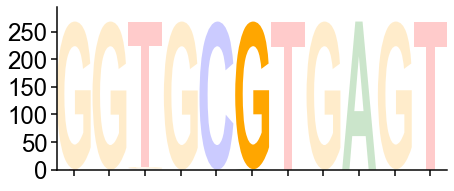

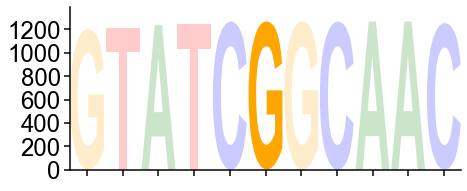

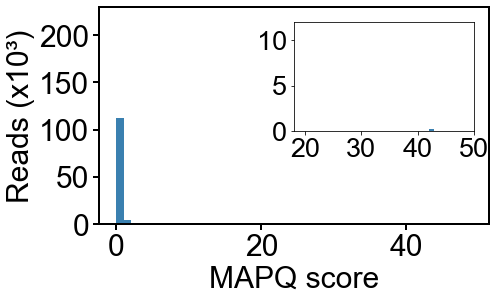

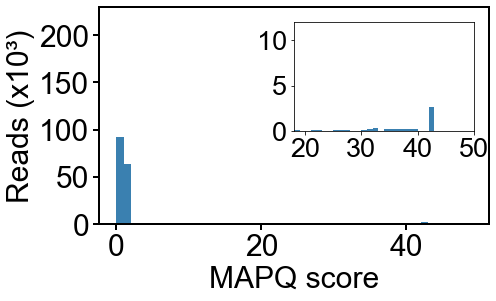

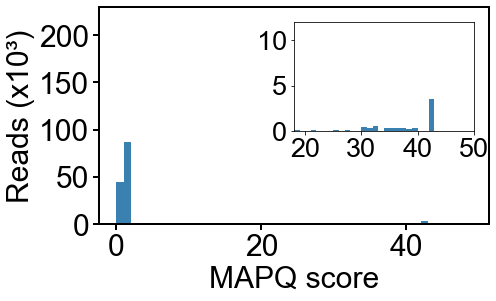

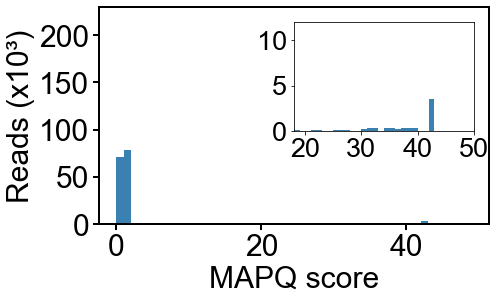

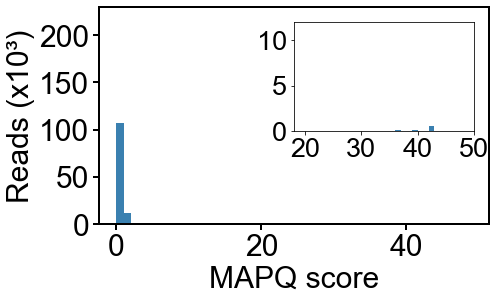

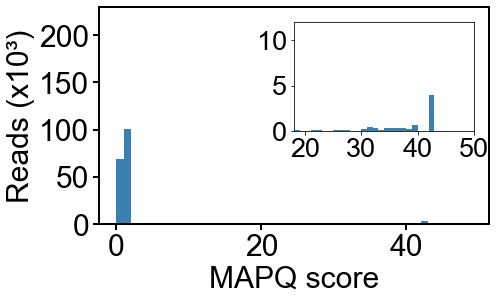

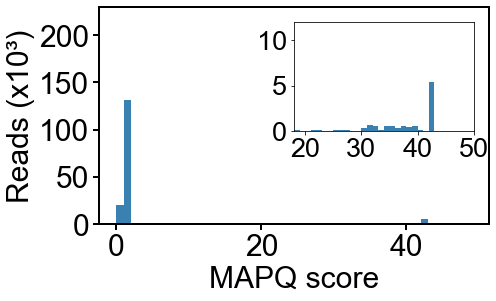

sample: NEG
A ON
0
A OFF
33.5
C ON
0
C OFF
57.5
D ON
0
D OFF
11.0
E ON
0
E OFF
2.5
F ON
0
F OFF
20.5
sample: POS
A ON
113.0
A OFF
633.5
C ON
54.0
C OFF
564.0
D ON
61.0
D OFF
376.0
E ON
20.0
E OFF
154.5
F ON
94.0
F OFF
456.5
sample: A
A ON
894.0
A OFF
2944.5
C ON
0
C OFF
0
D ON
0
D OFF
0
E ON
0
E OFF
0
F ON
0
F OFF
0
sample: C
A ON
0
A OFF
0
C ON
167.0
C OFF
3054.5
D ON
0
D OFF
0
E ON
0
E OFF
0
F ON
0
F OFF
0
sample: D
A ON
0
A OFF
0
C ON
0
C OFF
0
D ON
69.0
D OFF
401.5
E ON
0
E OFF
0
F ON
0
F OFF
0
sample: E
A ON
0
A OFF
0
C ON
0
C OFF
0
D ON
0
D OFF
4.0
E ON
268.0
E OFF
3642.0
F ON
0
F OFF
0
sample: F
A ON
0
A OFF
0
C ON
0
C OFF
0
D ON
0
D OFF
0
E ON
0
E OFF
0
F ON
1267.0
F OFF
4429.5


In [20]:
#replicate 3

files=glob.glob('NGS_fig5_rep3/*.sam')
# for f in files:
#     print(f + '/n')
    
profiles={}
seqs={}
quals={}
mapqs={}

samples=['NEG', 'POS', 'A', 'C', 'D', 'E', 'F']


#import files
for sample in samples:
    f='NGS_fig5_rep3/' + sample + '.sam'
    profiles[sample], seqs[sample], quals[sample], mapqs[sample]= read_sam_file2(f)
    
#plot profiles
for sample in samples:
    for key, color in zip(['A', 'C', 'D', 'E', 'F'], pastels):
        if key in profiles[sample].keys():
            print(sample)
            plot_ON_profile(profiles[sample], key, color, sample+'_'+key)
        if key+'_term' in profiles[sample].keys():
            plot_OFF_profile(profiles[sample], key, color, sample+'_'+key)

fs=30
w=.5
x=7*w
ms=7
lw=2
# plot logos
for sample in samples: 
    for key in ['A', 'C', 'D', 'E', 'F']:
        if key in profiles[sample].keys():
            fig, ax=plt.subplots(figsize=(7, 3))
            plot_logo(seqs[sample][key], SNP_loc[key], 5, ax, 1.1*profiles[sample][key][SNP_loc[key]])
            plt.show()
            plt.tight_layout()
#             fig.savefig(output + '/logo_' + sample+ '_' + key+'_630.pdf', bbox_inches='tight')
            plt.close()

#plot MAPQ scores
for sample in samples:
    plot_mapq(mapqs[sample], 'mapq_'+sample)


#calculate read counts
for sample in samples:
    print('sample: '+sample)
    get_read_counts(profiles[sample], darks, pastels, sample)


In [31]:
# compile read counts from above into spreadsheet -> load
reads=pd.read_csv('read_counts.csv')
reads
# use these to generate read-count plots in fig 5e and SI fig 15
# table shows number of reads aligned to each recorder sequence (columns) for each sample (rows)
# columns: name of recorder sequence, where A_on = SEN1delDT (no terminator), A_off=SEN1 (with terminator), etc.
# rows: sample name (same naming convention as above), where 5_18= rep1, 6_14=rep 2, and 6_30= rep3


,sample,date,A_on,A_off,C_on,C_off,D_on,D_off,E_on,E_off,F_on,F_off
0,NEG,5_18,0,842.0,0,1043.0,0,508.0,0,279.0,0,705.0
1,POS,5_18,189,792.5,438,1259.5,85,406.5,68,363.5,78,498.0
2,A,5_18,751,3134.0,0,0.0,0,0.0,0,0.0,0,0.0
3,C,5_18,0,0.0,976,2250.5,0,0.0,0,0.0,0,0.0
4,D,5_18,0,0.0,0,0.0,878,2907.0,0,0.0,0,0.0
5,E,5_18,0,0.0,0,0.0,0,0.0,925,3297.0,0,0.0
6,F,5_18,0,0.0,0,0.0,0,0.0,0,0.0,621,3215.5
7,NEG,6_14,0,966.0,0,747.5,0,524.5,0,328.5,0,717.0
8,POS,6_14,309,931.0,50,271.5,26,228.5,28,205.0,76,326.5
9,A,6_14,1212,3525.5,0,0.0,0,0.0,0,0.0,0,0.0
